In [1]:
import gc
import numpy as np
from omegaconf import DictConfig
import os
import pandas as pd
import lightning.pytorch as pl
import torch
from tqdm import tqdm
import yaml

from lightning_pose.data.dali import PrepareDALI
from lightning_pose.utils.io import ckpt_path_from_base_path
from lightning_pose.utils.predictions import (
    get_cfg_file, 
    predict_single_video, 
    load_model_from_checkpoint, 
    PredictionHandler,
)
from lightning_pose.utils.scripts import (
    compute_metrics,
    get_imgaug_transform, 
    get_dataset, 
    get_data_module,
)

from eks.utils import convert_lp_dlc, make_output_dataframe, populate_output_dataframe
from eks.singlecam_smoother import ensemble_kalman_smoother_singlecam

from pseudo_labeler.utils import format_data_walk
from pseudo_labeler.evaluation import compute_likelihoods_and_variance

dataset_name = "mirror-mouse"
n_hand_labels = 100
n_pseudo_labels = 1000
seeds=[0, 1, 2, 3]
# dataset_name = "mirror-fish"
# dataset_name = "crim13"

# where the labeled data is stored
data_dir = f"/teamspace/studios/this_studio/data/{dataset_name}"

# where the video snippets are stored
videos_dir = f"{data_dir}/videos-for-each-labeled-frame"

# where the hand labels are stored
hand_label_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/hand_label"

# where the network models are stored
networks_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/networks"

# where to save eks/post-processor outputs
eks_save_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/post-processors/eks_rng={seeds[0]}-{seeds[-1]}/eks_ood_snippets"

aeks_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/results_amortized_eks"

# where to save aeks_eks outputs
aeks_eks_save_dir = f"/teamspace/studios/this_studio/outputs/{dataset_name}/hand={n_hand_labels}_pseudo={n_pseudo_labels}/results_amortized_eks/eks_rng=0-3"

# where model configs are stored
config_dir = f"/teamspace/studios/this_studio/keypoint-pseudo-labeler/configs/"

# file name of csv where marker data is stored
ground_truth_csv = 'CollectedData_new.csv'



In [2]:

def find_model_dirs(base_dir, keyword):
    model_dirs = []
    for root, dirs, files in os.walk(base_dir):
        for dir_name in dirs:
            if keyword in dir_name:
                model_dirs.append(os.path.join(root, dir_name))
    return model_dirs

model_dirs_list = []
if dataset_name == "mirror-mouse":
    model_dirs_list = find_model_dirs(networks_dir, 'rng')
    print(f"Found {len(model_dirs_list)} model directories")
    keypoint_ensemble_list = [
        'paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'nose_top', 'tailBase_top', 'tailMid_top',
        'paw1LH_bot', 'paw2LF_bot', 'paw3RF_bot', 'paw4RH_bot', 'nose_bot', 'tailBase_bot', 'tailMid_bot',
    ]
else:
    raise NotImplementedError


Found 4 model directories


## Helper Functions:

In [3]:
def process_csv_for_sessions_and_frames(ground_truth_df):
    session_frame_info = []
    for idx, row in tqdm(ground_truth_df.iterrows(), total=len(ground_truth_df)):
        first_col_value = row[0]
        path_parts = first_col_value.split('/')
        session = path_parts[1]
        frame = path_parts[2]
        session_frame_info.append((session, frame))
    return session_frame_info

## Step 1: run inference on video snippets

In [4]:
def run_inference_on_snippets(model_dirs_list, data_dir, videos_dir, ground_truth_df):
    trainer = pl.Trainer(accelerator="gpu", devices=1)
    session_frame_info = process_csv_for_sessions_and_frames(ground_truth_df)
    
    for model_dir in model_dirs_list:
        print(f'Processing model in {os.path.basename(model_dir)}')
        cfg_file = os.path.join(model_dir, "config.yaml")
        model_cfg = DictConfig(yaml.safe_load(open(cfg_file)))
        
        # Update data directories
        model_cfg.data.data_dir = data_dir
        model_cfg.data.video_dir = os.path.join(data_dir, "videos")
        
        # Get model checkpoint
        ckpt_file = ckpt_path_from_base_path(model_dir, model_name=model_cfg.model.model_name)
        
        # Build datamodule
        cfg_new = model_cfg.copy()
        cfg_new.training.imgaug = 'default'
        imgaug_transform = get_imgaug_transform(cfg=cfg_new)
        dataset_new = get_dataset(cfg=cfg_new, data_dir=cfg_new.data.data_dir, imgaug_transform=imgaug_transform)
        datamodule_new = get_data_module(cfg=cfg_new, dataset=dataset_new, video_dir=cfg_new.data.video_dir)
        datamodule_new.setup()
        
        # Load model
        model = load_model_from_checkpoint(cfg=cfg_new, ckpt_file=ckpt_file, eval=True, data_module=datamodule_new)
        model.to("cuda")
        
        model_cfg.dali.base.sequence_length = 16

        for session, frame in tqdm(session_frame_info):
            video_file = os.path.join(videos_dir, session, frame.replace('png', 'mp4'))
            prediction_csv_file = os.path.join(model_dir, "video_preds_labeled", session, frame.replace('png', 'csv'))
            os.makedirs(os.path.join(model_dir, "video_preds_labeled", session), exist_ok=True)
            
            if not os.path.exists(video_file):
                print(f'Cannot find video snippet for {video_file}. Skipping')
                continue
            if os.path.exists(prediction_csv_file):
                print(f'Prediction csv file already exists for {session}/{frame}. Skipping')
                continue
            
            print(f'{video_file} saved as\n{prediction_csv_file}')
            cfg = get_cfg_file(cfg_file=cfg_new)
            model_type = "context" if cfg.model.model_type == "heatmap_mhcrnn" else "base"
            cfg.training.imgaug = "default"
            
            vid_pred_class = PrepareDALI(
                train_stage="predict",
                model_type=model_type,
                dali_config=cfg.dali,
                filenames=[video_file],
                resize_dims=[cfg.data.image_resize_dims.height, cfg.data.image_resize_dims.width]
            )
            
            # Get loader
            predict_loader = vid_pred_class()
            
            # Initialize prediction handler class
            pred_handler = PredictionHandler(cfg=cfg, data_module=datamodule_new, video_file=video_file)
            
            # Compute predictions
            preds = trainer.predict(model=model, dataloaders=predict_loader, return_predictions=True)
            
            # Process predictions
            preds_df = pred_handler(preds=preds)
            os.makedirs(os.path.dirname(prediction_csv_file), exist_ok=True)
            preds_df.to_csv(prediction_csv_file)
            
            # Clear up memory
            del predict_loader
            del pred_handler
            del vid_pred_class
            gc.collect()
            torch.cuda.empty_cache()
        
        del dataset_new
        del datamodule_new
        del model
        gc.collect()
        torch.cuda.empty_cache()

In [5]:
ground_truth_df = pd.read_csv(os.path.join(data_dir, ground_truth_csv), skiprows=2)
run_inference_on_snippets(model_dirs_list, data_dir, videos_dir, ground_truth_df)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
100%|██████████| 253/253 [00:00<00:00, 15705.05it/s]


Processing model in rng0
using default image augmentation pipeline (resizing only)
Number of labeled images in the full dataset (train+val+test): 100
Warning! Requested training frames exceeds training set size; using all
Dataset splits -- train: 80, val: 10, test: 10

 Initializing a HeatmapTracker instance.


100%|██████████| 253/253 [00:00<00:00, 5416.98it/s]


Prediction csv file already exists for 180607_004/img015278.png. Skipping
Prediction csv file already exists for 180607_004/img015320.png. Skipping
Prediction csv file already exists for 180607_004/img015814.png. Skipping
Prediction csv file already exists for 180607_004/img015879.png. Skipping
Prediction csv file already exists for 180607_004/img016209.png. Skipping
Prediction csv file already exists for 180607_004/img016400.png. Skipping
Prediction csv file already exists for 180607_004/img016437.png. Skipping
Prediction csv file already exists for 180607_004/img016434.png. Skipping
Prediction csv file already exists for 180607_004/img016429.png. Skipping
Prediction csv file already exists for 180607_004/img016542.png. Skipping
Prediction csv file already exists for 180607_004/img016558.png. Skipping
Prediction csv file already exists for 180607_004/img016635.png. Skipping
Prediction csv file already exists for 180607_004/img016630.png. Skipping
Prediction csv file already exists for

100%|██████████| 253/253 [00:00<00:00, 5743.76it/s]


Prediction csv file already exists for 180607_004/img015278.png. Skipping
Prediction csv file already exists for 180607_004/img015320.png. Skipping
Prediction csv file already exists for 180607_004/img015814.png. Skipping
Prediction csv file already exists for 180607_004/img015879.png. Skipping
Prediction csv file already exists for 180607_004/img016209.png. Skipping
Prediction csv file already exists for 180607_004/img016400.png. Skipping
Prediction csv file already exists for 180607_004/img016437.png. Skipping
Prediction csv file already exists for 180607_004/img016434.png. Skipping
Prediction csv file already exists for 180607_004/img016429.png. Skipping
Prediction csv file already exists for 180607_004/img016542.png. Skipping
Prediction csv file already exists for 180607_004/img016558.png. Skipping
Prediction csv file already exists for 180607_004/img016635.png. Skipping
Prediction csv file already exists for 180607_004/img016630.png. Skipping
Prediction csv file already exists for

100%|██████████| 253/253 [00:00<00:00, 5667.95it/s]


Prediction csv file already exists for 180607_004/img015278.png. Skipping
Prediction csv file already exists for 180607_004/img015320.png. Skipping
Prediction csv file already exists for 180607_004/img015814.png. Skipping
Prediction csv file already exists for 180607_004/img015879.png. Skipping
Prediction csv file already exists for 180607_004/img016209.png. Skipping
Prediction csv file already exists for 180607_004/img016400.png. Skipping
Prediction csv file already exists for 180607_004/img016437.png. Skipping
Prediction csv file already exists for 180607_004/img016434.png. Skipping
Prediction csv file already exists for 180607_004/img016429.png. Skipping
Prediction csv file already exists for 180607_004/img016542.png. Skipping
Prediction csv file already exists for 180607_004/img016558.png. Skipping
Prediction csv file already exists for 180607_004/img016635.png. Skipping
Prediction csv file already exists for 180607_004/img016630.png. Skipping
Prediction csv file already exists for

100%|██████████| 253/253 [00:00<00:00, 3028.38it/s]


Prediction csv file already exists for 180607_004/img015278.png. Skipping
Prediction csv file already exists for 180607_004/img015320.png. Skipping
Prediction csv file already exists for 180607_004/img015814.png. Skipping
Prediction csv file already exists for 180607_004/img015879.png. Skipping
Prediction csv file already exists for 180607_004/img016209.png. Skipping
Prediction csv file already exists for 180607_004/img016400.png. Skipping
Prediction csv file already exists for 180607_004/img016437.png. Skipping
Prediction csv file already exists for 180607_004/img016434.png. Skipping
Prediction csv file already exists for 180607_004/img016429.png. Skipping
Prediction csv file already exists for 180607_004/img016542.png. Skipping
Prediction csv file already exists for 180607_004/img016558.png. Skipping
Prediction csv file already exists for 180607_004/img016635.png. Skipping
Prediction csv file already exists for 180607_004/img016630.png. Skipping
Prediction csv file already exists for

## Step 2: run EKS

In [6]:
def run_eks_on_snippets(videos_dir, model_dirs_list, eks_save_dir, ground_truth_df):
    session_frame_info = process_csv_for_sessions_and_frames(ground_truth_df)
    tracker_name = 'heatmap_tracker'
    keypoint_names = None

    # store useful info here
    index_list = []
    results_list = []

    # Step 1: Process and save the CSVs
    for session, frame in session_frame_info:
        # extract all markers
        markers_list = []
        for model_dir in model_dirs_list:
            csv_file = os.path.join(
                model_dir, 'video_preds_labeled', session, frame.replace('png', 'csv'))
            df_tmp = pd.read_csv(csv_file, header=[0, 1, 2], index_col=0)
            keypoint_names = [l[1] for l in df_tmp.columns[::3]]
            markers_tmp = convert_lp_dlc(df_tmp, keypoint_names, model_name=tracker_name)
            markers_list.append(markers_tmp)

        dfs_markers = markers_list
        # make empty dataframe to write results into
        df_eks = make_output_dataframe(df_tmp)

        # Convert list of DataFrames to a 3D NumPy array
        data_arrays = [df.to_numpy() for df in markers_list]
        markers_3d_array = np.stack(data_arrays, axis=0)

        # Map keypoint names to keys in input_dfs and crop markers_3d_array
        keypoint_is = {}
        keys = []
        for i, col in enumerate(markers_list[0].columns):
            keypoint_is[col] = i
        for part in keypoint_ensemble_list:
            keys.append(keypoint_is[part + '_x'])
            keys.append(keypoint_is[part + '_y'])
            keys.append(keypoint_is[part + '_likelihood'])
        key_cols = np.array(keys)
        markers_3d_array = markers_3d_array[:, :, key_cols]

        save_dir = os.path.join(eks_save_dir, 'eks', session)
        save_file = os.path.join(save_dir, frame.replace('png', 'csv'))
        if os.path.exists(save_file):
            print(f'Skipping ensembling for {session}/{frame} as it already exists.')
            continue
        else:
            print(f'Ensembling for {session}/{frame}')
            # Call the smoother function
            df_dicts, s_finals = ensemble_kalman_smoother_singlecam(
                markers_3d_array,
                keypoint_ensemble_list,
                smooth_param=None,
                s_frames=[(None, None)],
                blocks=[],
            )
            # put results into new dataframe
            for k, keypoint_name in enumerate(keypoint_ensemble_list):
                keypoint_df = df_dicts[k][keypoint_name + '_df']
                df_eks = populate_output_dataframe(keypoint_df, keypoint_name, df_eks)

            # save eks results
            os.makedirs(save_dir, exist_ok=True)
            df_eks.to_csv(save_file)

    # Step 2: Extract center frame results
    print('Extracting center frame results from all sessions.')
    for session, frame in session_frame_info:
        # Construct the path to the saved EKS results
        save_file = os.path.join(eks_save_dir, 'eks', session, frame.replace('png', 'csv'))
        if not os.path.exists(save_file):
            print(f'Missing EKS file for {session}/{frame}. Skipping.')
            continue

        # read csv
        df_eks = pd.read_csv(save_file, header=[0, 1, 2], index_col=0)
        
        # extract result from center frame
        assert df_eks.shape[0] & 2 != 0
        idx_frame = int(np.floor(df_eks.shape[0] / 2))
        frame_file = frame.replace('.mp4', '.png')
        index_name = f'labeled-data/{session}/{frame_file}'
        result = df_eks[df_eks.index == idx_frame].rename(index={idx_frame: index_name})
        results_list.append(result)

    # save final predictions
    results_df = pd.concat(results_list)
    results_df.sort_index(inplace=True)
    # add "set" column so this df is interpreted as labeled data predictions
    results_df.loc[:, ("set", "", "")] = "train"
    results_df.to_csv(os.path.join(eks_save_dir, 'eks', 'predictions_new.csv'))

    return df_eks, dfs_markers

In [7]:
df_eks, dfs_markers = run_eks_on_snippets(videos_dir, model_dirs_list, eks_save_dir, ground_truth_df)

100%|██████████| 253/253 [00:00<00:00, 13447.20it/s]
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Ensembling for 180607_004/img015278.png
Ensembling models
Ensembling for 180607_004/img015320.png
Ensembling models
Ensembling for 180607_004/img015814.png
Ensembling models
Ensembling for 180607_004/img015879.png
Ensembling models
Ensembling for 180607_004/img016209.png
Ensembling models
Ensembling for 180607_004/img016400.png
Ensembling models
Ensembling for 180607_004/img016437.png
Ensembling models
Ensembling for 180607_004/img016434.png
Ensembling models
Ensembling for 180607_004/img016429.png
Ensembling models
Ensembling for 180607_004/img016542.png
Ensembling models
Ensembling for 180607_004/img016558.png
Ensembling models
Ensembling for 180607_004/img016635.png
Ensembling models
Ensembling for 180607_004/img016630.png
Ensembling models
Ensembling for 180607_004/img016831.png
Ensembling models
Ensembling for 180607_004/img016958.png
Ensembling models
Ensembling for 180607_004/img017025.png
Ensembling models
Ensembling for 180607_004/img017052.png
Ensembling models
Ensembling for

In [8]:
print(len(dfs_markers))

4


## Step 2.5: sanity check EKS dfs

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

def plot_eks_dfs(keypoint_ensemble_list, markers_list, df_eks):
    """
    Plots the EKS DataFrames for the given keypoints.

    Parameters:
    - keypoint_ensemble_list: List of keypoints to plot.
    - markers_list: List of DataFrames containing marker data.
    - df_eks: DataFrame containing the ensemble kalman smoother results.
    """
    for kp in keypoint_ensemble_list:
        fig, axes = plt.subplots(2, 1, figsize=(12, 6))
        for ax, coord in zip(axes, ['x', 'y']):
            cols0 = (f'{kp}_{coord}')
            cols1 = ('ensemble-kalman_tracker', kp, coord)
            for i, df in enumerate(markers_list):
                m = df.loc[:, cols0]
                color = [0.5, 0.5, 0.5] # if i < 5 else [0, 0, 1]  # Use grey for rng0-4 and red for rng5 and beyond
                ax.plot(m.to_numpy(), color=color)
            m = df_eks.loc[:, cols1]
            ax.plot(m, color='k')
            ax.set_title(cols0)
        plt.show()

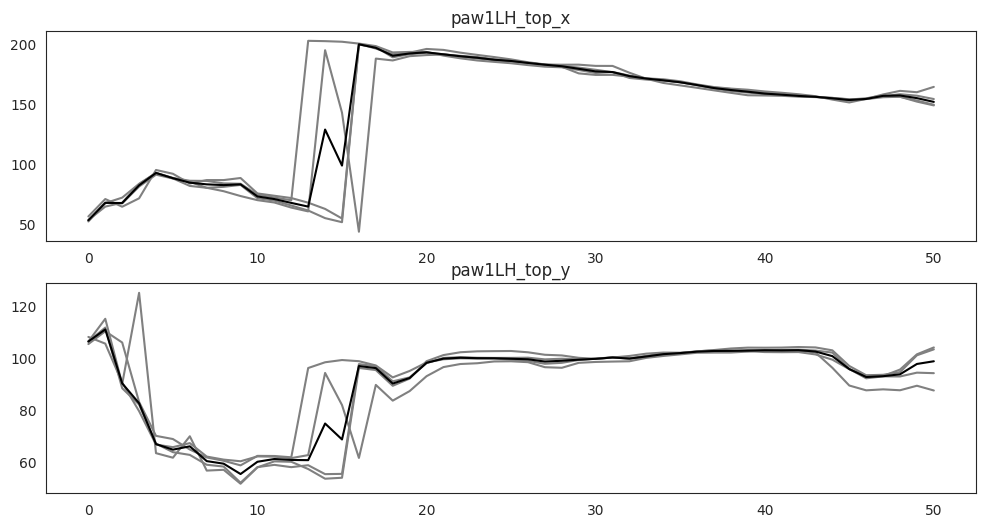

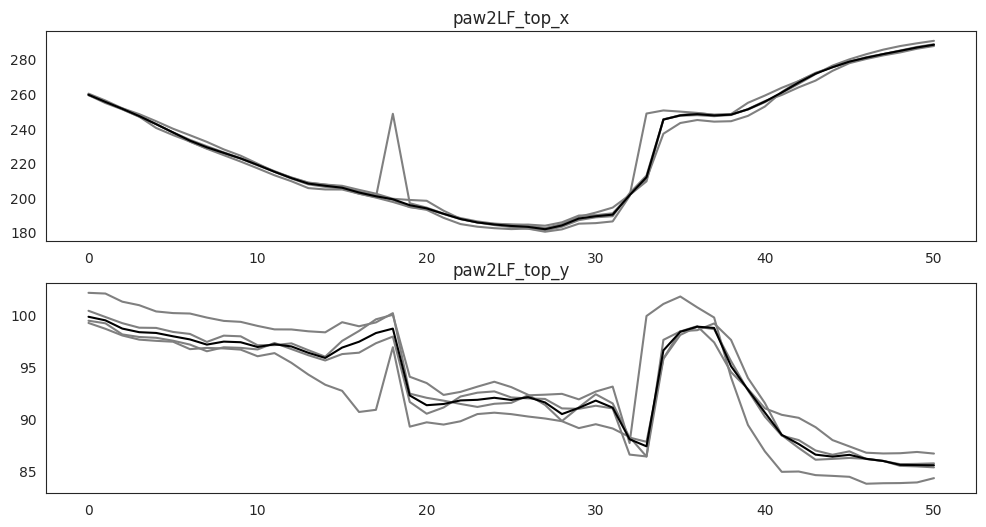

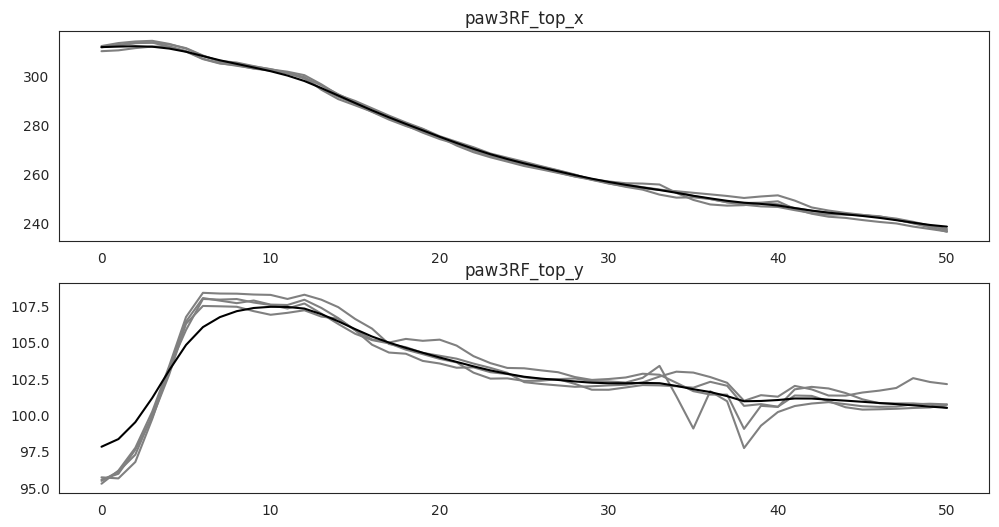

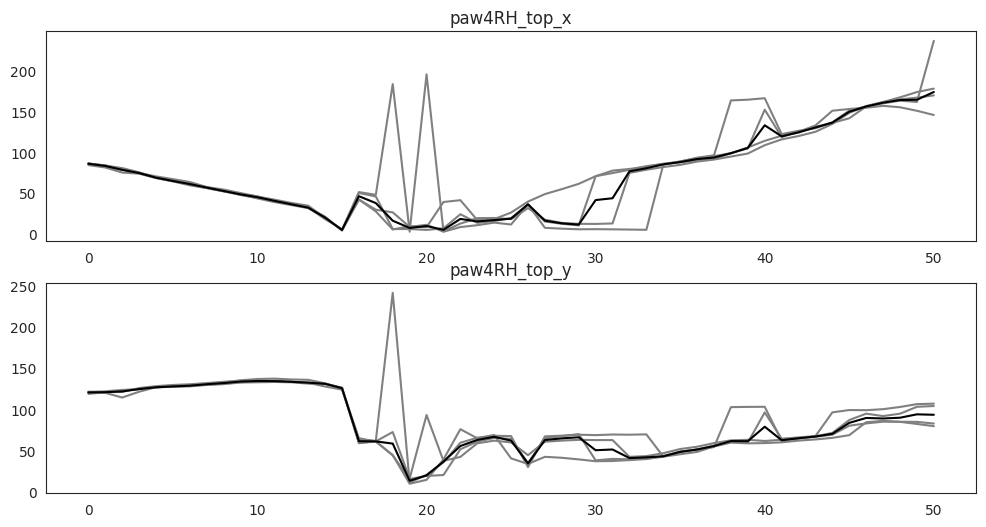

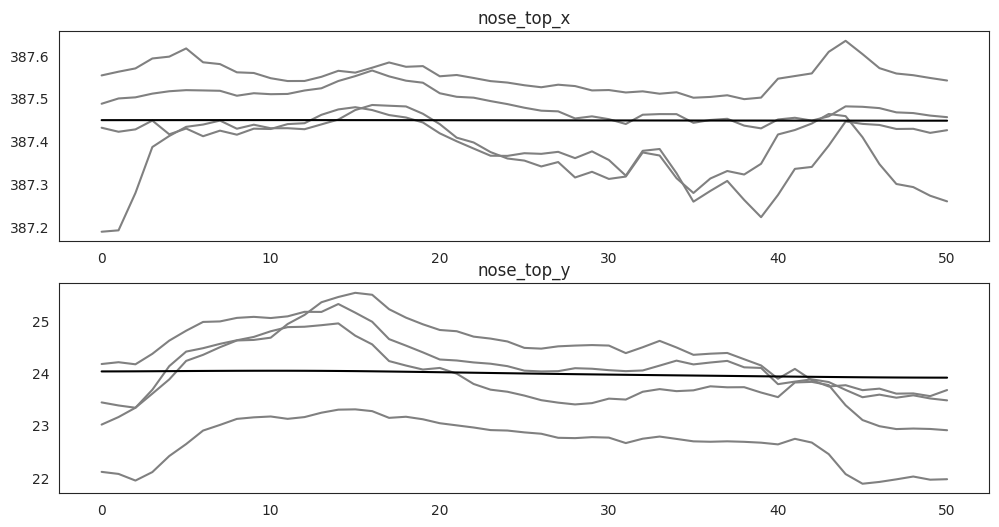

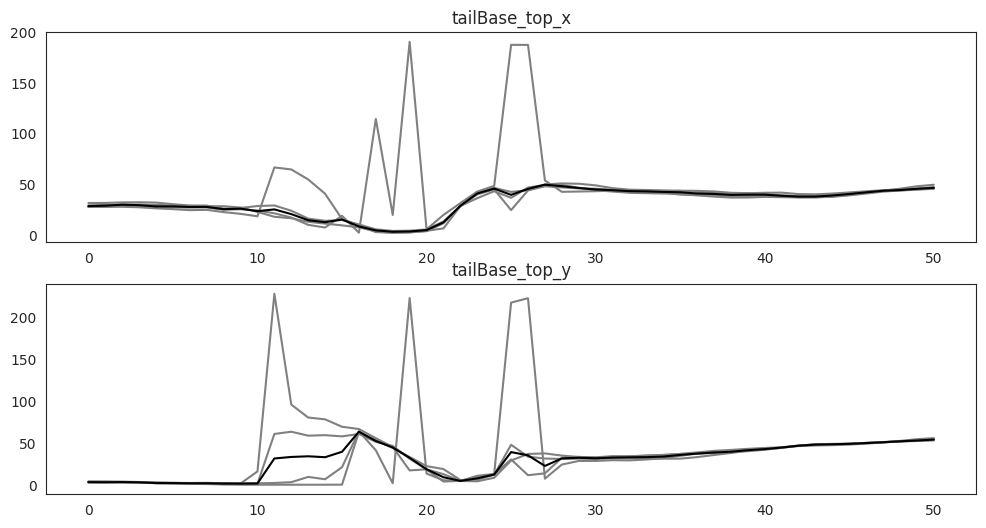

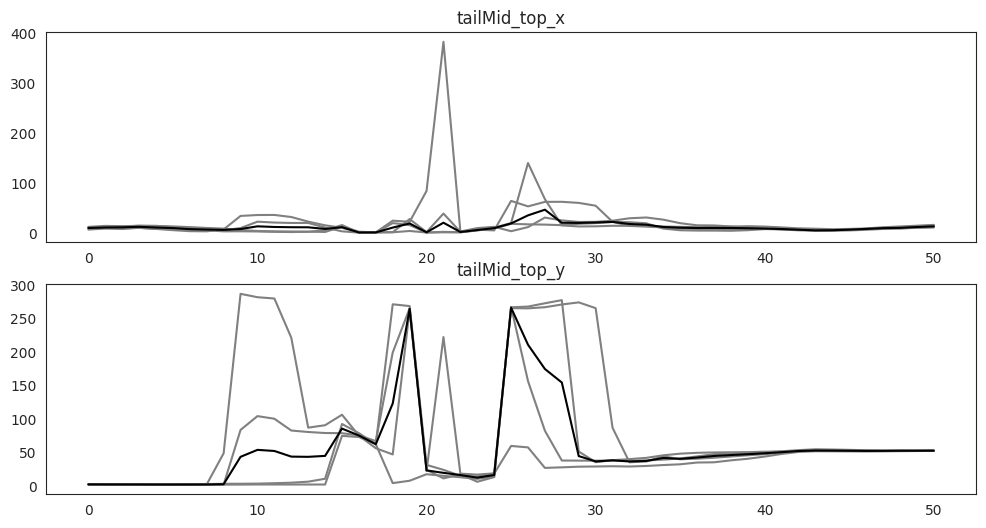

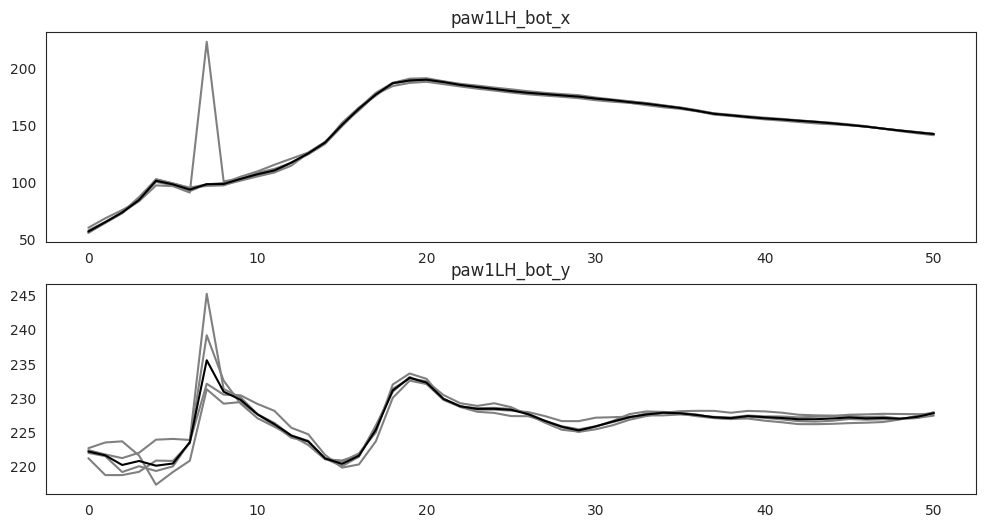

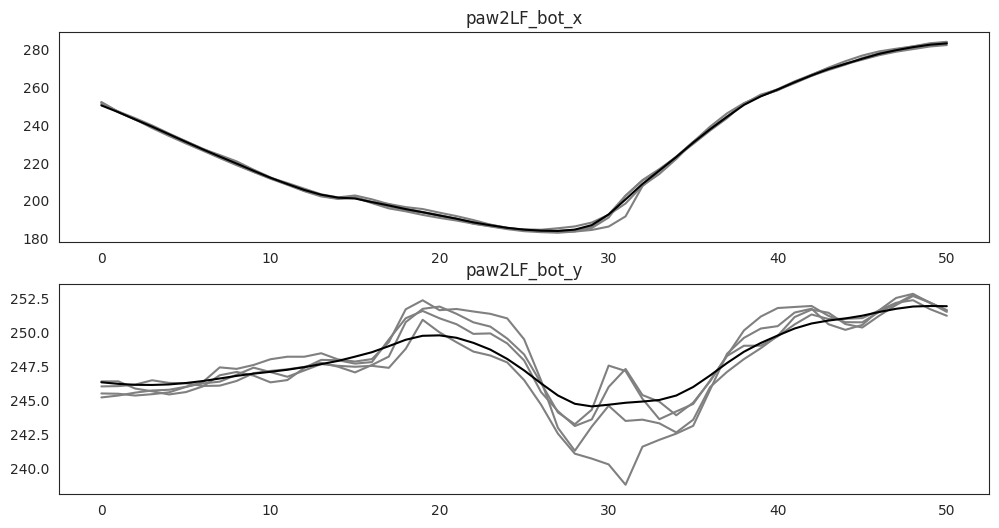

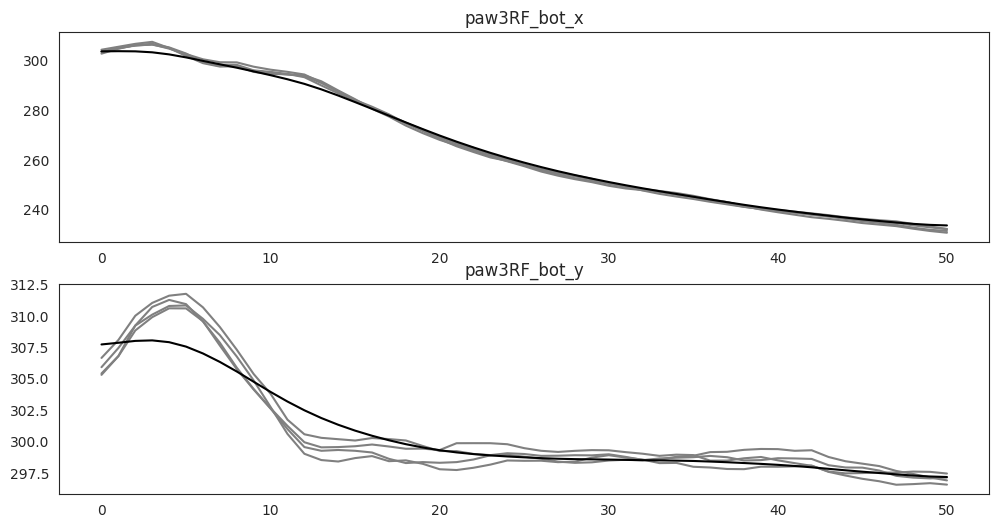

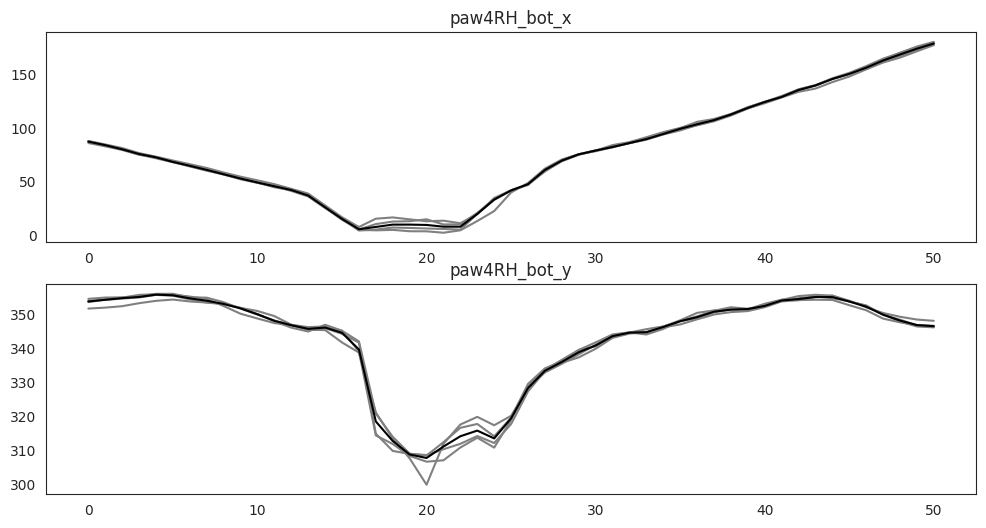

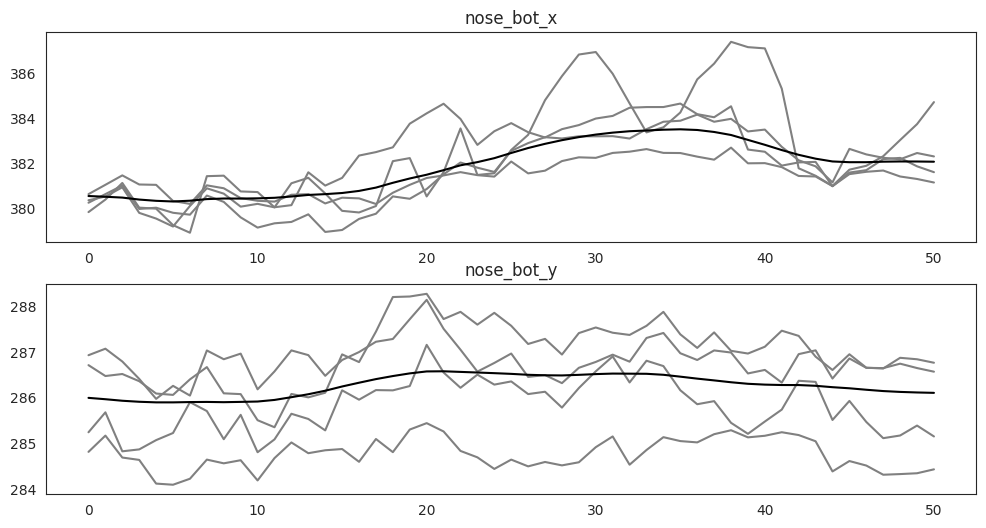

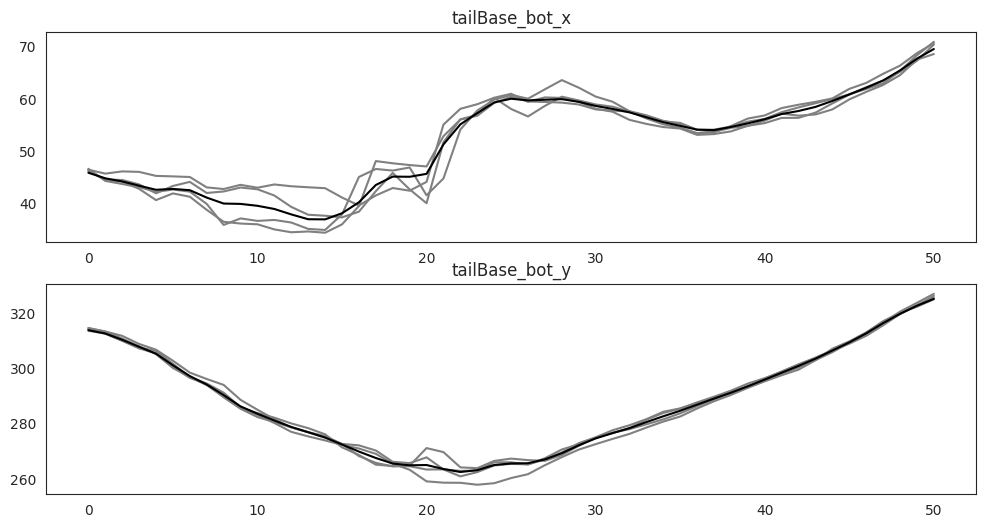

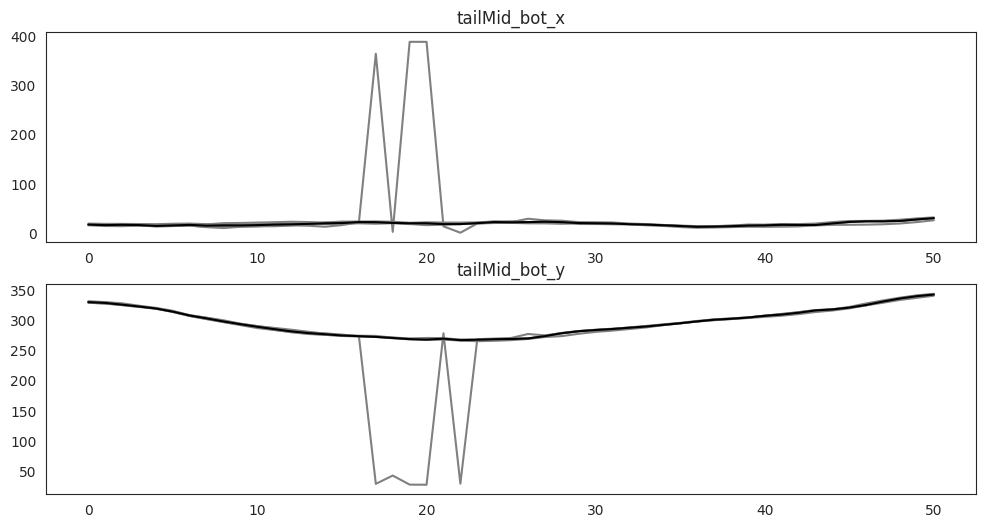

In [10]:
plot_eks_dfs(keypoint_ensemble_list, dfs_markers, df_eks)

## Step 3: compute ens mean/median

### collect predictions from individual models

In [11]:
def collect_preds(model_dirs_list, videos_dir):
    for model_dir in tqdm(model_dirs_list):
        results_list = []
        sessions = os.listdir(videos_dir)
        for session in sessions:
            frames = os.listdir(os.path.join(videos_dir, session))
            for frame in frames:
                # Load prediction on snippet
                df = pd.read_csv(
                    os.path.join(model_dir, 'video_preds_labeled', session, frame.replace('.mp4', '.csv')), 
                    header=[0, 1, 2], 
                    index_col=0,
                )
                # Extract result from center frame
                assert df.shape[0] & 2 != 0
                idx_frame = int(np.floor(df.shape[0] / 2))
                frame_file = frame.replace('.mp4', '.png')
                index_name = f'labeled-data/{session}/{frame_file}'
                result = df[df.index == idx_frame].rename(index={idx_frame: index_name})
                results_list.append(result)

        # Save final predictions
        results_df = pd.concat(results_list)
        results_df.sort_index(inplace=True)
        # Add "set" column so this df is interpreted as labeled data predictions
        results_df.loc[:, ("set", "", "")] = "train"
        results_df.to_csv(os.path.join(model_dir, 'video_preds_labeled', 'predictions_new.csv'))



In [12]:
collect_preds(model_dirs_list, videos_dir)

100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


### compute ens mean/median

In [13]:
def compute_ens_mean_median(model_dirs_list, eks_save_dir, post_processor_type):
    markers_list = []
    for model_dir in model_dirs_list:
        csv_file = os.path.join(model_dir, 'video_preds_labeled', 'predictions_new.csv')
        df_tmp = pd.read_csv(csv_file, header=[0, 1, 2], index_col=0)
        preds_curr = df_tmp.to_numpy()[:, :-1]  # remove "set" column
        preds_curr = np.delete(preds_curr, list(range(2, preds_curr.shape[1], 3)), axis=1)
        preds_curr = np.reshape(preds_curr, (preds_curr.shape[0], -1, 2))
        markers_list.append(preds_curr[..., None])
    
    # Concatenate across last dim
    pred_arrays = np.concatenate(markers_list, axis=3)
    
    # Compute mean/median across x/y
    if post_processor_type == 'ens-mean':
        ens_mean = np.mean(pred_arrays, axis=3)
    elif post_processor_type == 'ens-median':
        ens_mean = np.median(pred_arrays, axis=3)
    
    ens_likelihood = np.nan * np.zeros((ens_mean.shape[0], ens_mean.shape[1], 1))
    
    # Build dataframe
    xyl = np.concatenate([ens_mean, ens_likelihood], axis=2)
    df_final = pd.DataFrame(
        xyl.reshape(ens_mean.shape[0], -1), 
        columns=df_tmp.columns[:-1],  # remove "set" column, add back in later
        index=df_tmp.index
    )
    df_final.sort_index(inplace=True)
    # Add "set" column so this df is interpreted as labeled data predictions
    df_final.loc[:, ("set", "", "")] = "train"
    save_dir_ = os.path.join(eks_save_dir, f'{post_processor_type}')
    os.makedirs(save_dir_, exist_ok=True)
    df_final.to_csv(os.path.join(save_dir_, 'predictions_new.csv'))

In [14]:
compute_ens_mean_median(model_dirs_list, eks_save_dir, 'ens-mean')
compute_ens_mean_median(model_dirs_list, eks_save_dir, 'ens-median')

## Step 4: compute metrics

### step 4.1: create data module to have access to labeled data

In [15]:
cfg_file = os.path.join(config_dir, f"config_{dataset_name}.yaml")
cfg = DictConfig(yaml.safe_load(open(cfg_file)))

model_cfg = cfg.copy()

model_cfg.data.data_dir = data_dir
model_cfg.data.csv_file = ground_truth_csv

# model_cfg.data.data_dir = '/media/mattw/behavior/pose-estimation-data/mirror-fish/raw/'
# model_cfg.data.csv_file = 'CollectedData_new_infilled.csv'

model_cfg.training.imgaug = "default"
model_cfg.training.train_prob = 1
model_cfg.training.val_prob = 0
model_cfg.training.train_frames = 1

imgaug_transform = get_imgaug_transform(cfg=model_cfg)
dataset = get_dataset(
    cfg=model_cfg, 
    data_dir=model_cfg.data.data_dir, 
    imgaug_transform=imgaug_transform)
data_module = get_data_module(
    cfg=model_cfg, 
    dataset=dataset, 
    video_dir=os.path.join(data_dir, dataset_name, "videos"))
data_module.setup()

using default image augmentation pipeline (resizing only)
Number of labeled images in the full dataset (train+val+test): 253
Dataset splits -- train: 253, val: 0, test: 0


### step 4.2: compute metrics on ensemble members

In [16]:
for model_dir in model_dirs_list:
    print(model_dir)
    preds_file = os.path.join(model_dir, 'video_preds_labeled', 'predictions_new.csv')
    compute_metrics(cfg=model_cfg, preds_file=preds_file, data_module=data_module)


/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng0
Results of running PCA (pca_singleview) on keypoints:
Kept 14/28 components, and found:
Explained variance ratio: [0.443 0.183 0.136 0.064 0.055 0.042 0.021 0.012 0.01  0.008 0.006 0.005
 0.004 0.003 0.003 0.002 0.002 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 14 components: 0.991
Results of running PCA (pca_multiview) on keypoints:
Kept 3/4 components, and found:
Explained variance ratio: [0.891 0.072 0.036 0.   ]
Variance explained by 3 components: 1.0
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/networks/rng1
Results of running PCA (pca_singleview) on keypoints:
Kept 14/28 components, and found:
Explained variance ratio: [0.443 0.183 0.136 0.064 0.055 0.042 0.021 0.012 0.01  0.008 0.006 0.005
 0.004 0.003 0.003 0.002 0.002 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 14 components: 0.9

### step 4.3: compute metrics on post-processed traces

In [17]:
post_processor_types = [
    "ens-mean",
    "ens-median",
    "eks",
]

for post_processor_type in post_processor_types:
    print(f'{post_processor_type}')
    preds_file = os.path.join(eks_save_dir, f'{post_processor_type}', 'predictions_new.csv')
    compute_metrics(cfg=model_cfg, preds_file=preds_file, data_module=data_module)


ens-mean
Results of running PCA (pca_singleview) on keypoints:
Kept 14/28 components, and found:
Explained variance ratio: [0.443 0.183 0.136 0.064 0.055 0.042 0.021 0.012 0.01  0.008 0.006 0.005
 0.004 0.003 0.003 0.002 0.002 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 14 components: 0.991
Results of running PCA (pca_multiview) on keypoints:
Kept 3/4 components, and found:
Explained variance ratio: [0.891 0.072 0.036 0.   ]
Variance explained by 3 components: 1.0
ens-median
Results of running PCA (pca_singleview) on keypoints:
Kept 14/28 components, and found:
Explained variance ratio: [0.443 0.183 0.136 0.064 0.055 0.042 0.021 0.012 0.01  0.008 0.006 0.005
 0.004 0.003 0.003 0.002 0.002 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 14 components: 0.991
Results of running PCA (pca_multiview) on keypoints:
Kept 3/4 components, and found:
Explained variance ratio: [0.891 0.072 0.036 0.   ]
Variance expla

## Step 5: run everything again with expanded dataset

In [18]:
model_dirs_list = []
if dataset_name == "mirror-mouse":
    model_dirs_list = find_model_dirs(aeks_dir, 'rng')
    keypoint_ensemble_list = [
        'paw1LH_top', 'paw2LF_top', 'paw3RF_top', 'paw4RH_top', 'nose_top', 'tailBase_top', 'tailMid_top',
        'paw1LH_bot', 'paw2LF_bot', 'paw3RF_bot', 'paw4RH_bot', 'nose_bot', 'tailBase_bot', 'tailMid_bot',
    ]
else:
    raise NotImplementedError

# remove eks_rng=0-3
for directory in model_dirs_list:
    if 'eks' in os.path.basename(directory):
        print(f"{directory} has 'eks' in it. Removing")
        model_dirs_list.remove(directory)
print(f"Found {len(model_dirs_list)} model directories")

# 1. running inference
run_inference_on_snippets(model_dirs_list, data_dir, videos_dir, ground_truth_df)

# 2. running EKS
df_eks, dfs_markers = run_eks_on_snippets(videos_dir, model_dirs_list, aeks_eks_save_dir, ground_truth_df)

# 3.1 collect preds from aeks models
collect_preds(model_dirs_list, videos_dir)
# 3.2 compute ens mean and median
compute_ens_mean_median(model_dirs_list, aeks_eks_save_dir, 'ens-mean')
compute_ens_mean_median(model_dirs_list, aeks_eks_save_dir, 'ens-median')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/eks_rng=0-3 has 'eks' in it. Removing
Found 4 model directories


100%|██████████| 253/253 [00:00<00:00, 16049.71it/s]

Processing model in rng0
using default image augmentation pipeline (resizing only)


Number of labeled images in the full dataset (train+val+test): 1088
Dataset splits -- train: 100, val: 108, test: 110

 Initializing a HeatmapTracker instance.


  0%|          | 0/253 [00:00<?, ?it/s]

/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015278.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img015278.csv


[/opt/dali/dali/operators/image/crop/new_crop_mirror_normalize.cu:249] using CropMirrorNormalize legacy implementation
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 1/253 [00:04<17:28,  4.16s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015320.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img015320.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  1%|          | 2/253 [00:05<09:25,  2.25s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015814.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img015814.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  1%|          | 3/253 [00:05<06:49,  1.64s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015879.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img015879.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 4/253 [00:06<05:36,  1.35s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016209.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img016209.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 5/253 [00:07<04:54,  1.19s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016400.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img016400.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 6/253 [00:08<04:28,  1.09s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016437.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img016437.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  3%|▎         | 7/253 [00:09<04:13,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016434.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img016434.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  3%|▎         | 8/253 [00:10<04:01,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016429.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img016429.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▎         | 9/253 [00:11<03:53,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016542.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img016542.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▍         | 10/253 [00:12<03:48,  1.07it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016558.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img016558.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▍         | 11/253 [00:13<03:44,  1.08it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img016635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  5%|▍         | 12/253 [00:14<03:41,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016630.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img016630.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  5%|▌         | 13/253 [00:14<03:39,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016831.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img016831.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▌         | 14/253 [00:15<03:38,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016958.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img016958.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▌         | 15/253 [00:16<03:36,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017025.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017025.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▋         | 16/253 [00:17<03:35,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017052.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017052.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  7%|▋         | 17/253 [00:18<03:34,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017056.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017056.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  7%|▋         | 18/253 [00:19<03:32,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017057.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017057.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 19/253 [00:20<03:31,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017059.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017059.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 20/253 [00:21<03:30,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017093.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017093.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 21/253 [00:22<03:29,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017117.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017117.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▊         | 22/253 [00:23<03:28,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017126.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017126.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▉         | 23/253 [00:24<03:28,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017142.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017142.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▉         | 24/253 [00:24<03:26,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017145.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017145.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 10%|▉         | 25/253 [00:25<03:26,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017148.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017148.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 10%|█         | 26/253 [00:26<03:25,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017209.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017209.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█         | 27/253 [00:27<03:24,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017213.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017213.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█         | 28/253 [00:28<03:23,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017245.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017245.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█▏        | 29/253 [00:29<03:22,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017244.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017244.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 12%|█▏        | 30/253 [00:30<03:21,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017271.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017271.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 12%|█▏        | 31/253 [00:31<03:20,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017308.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017308.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 32/253 [00:32<03:19,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017307.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017307.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 33/253 [00:33<03:18,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017330.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017330.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 34/253 [00:33<03:18,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017336.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017336.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 14%|█▍        | 35/253 [00:34<03:17,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017342.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017342.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 14%|█▍        | 36/253 [00:35<03:16,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017345.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017345.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▍        | 37/253 [00:36<03:15,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017348.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017348.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▌        | 38/253 [00:37<03:14,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017351.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017351.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▌        | 39/253 [00:38<03:13,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017456.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017456.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 16%|█▌        | 40/253 [00:39<03:12,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017457.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017457.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 16%|█▌        | 41/253 [00:40<03:12,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017548.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017548.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 42/253 [00:41<03:10,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017656.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017656.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 43/253 [00:42<03:09,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017702.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img017702.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 44/253 [00:43<03:09,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018263.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img018263.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 18%|█▊        | 45/253 [00:43<03:07,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018464.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img018464.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 18%|█▊        | 46/253 [00:44<03:06,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018594.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img018594.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▊        | 47/253 [00:45<03:05,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018588.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img018588.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▉        | 48/253 [00:46<03:04,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018681.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img018681.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▉        | 49/253 [00:47<03:03,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018677.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img018677.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 20%|█▉        | 50/253 [00:48<03:03,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018905.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img018905.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 20%|██        | 51/253 [00:49<03:02,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018906.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img018906.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██        | 52/253 [00:50<03:01,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img019476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img019476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██        | 53/253 [00:51<03:00,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020114.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img020114.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██▏       | 54/253 [00:52<02:59,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img020119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 22%|██▏       | 55/253 [00:52<02:58,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020234.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img020234.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 22%|██▏       | 56/253 [00:53<02:58,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020248.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img020248.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 57/253 [00:54<02:57,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020249.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img020249.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 58/253 [00:55<02:55,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020265.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img020265.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 59/253 [00:56<02:55,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020415.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img020415.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 24%|██▎       | 60/253 [00:57<02:55,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020446.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img020446.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 24%|██▍       | 61/253 [00:58<02:54,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img021476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▍       | 62/253 [00:59<02:53,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021632.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img021632.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▍       | 63/253 [01:00<02:52,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img021635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▌       | 64/253 [01:01<02:51,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021641.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img021641.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▌       | 65/253 [01:02<02:50,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021698.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img021698.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▌       | 66/253 [01:02<02:49,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021757.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img021757.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▋       | 67/253 [01:03<02:48,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021760.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img021760.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 27%|██▋       | 68/253 [01:04<02:48,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021828.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img021828.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 27%|██▋       | 69/253 [01:05<02:47,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021883.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img021883.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 70/253 [01:06<02:45,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021884.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img021884.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 71/253 [01:07<02:44,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022065.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img022065.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 72/253 [01:08<02:43,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022372.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img022372.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 29%|██▉       | 73/253 [01:09<02:42,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022371.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img022371.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 29%|██▉       | 74/253 [01:10<02:41,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022546.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img022546.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|██▉       | 75/253 [01:11<02:41,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022567.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img022567.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|███       | 76/253 [01:11<02:41,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022611.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img022611.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|███       | 77/253 [01:12<02:39,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022612.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img022612.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 31%|███       | 78/253 [01:13<02:38,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024337.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img024337.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 31%|███       | 79/253 [01:14<02:36,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024441.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img024441.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 80/253 [01:15<02:35,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024525.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img024525.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 81/253 [01:16<02:35,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024565.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img024565.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 82/253 [01:17<02:34,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024575.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img024575.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 33%|███▎      | 83/253 [01:18<02:34,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024665.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img024665.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 33%|███▎      | 84/253 [01:19<02:33,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024667.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img024667.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▎      | 85/253 [01:20<02:32,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024804.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img024804.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▍      | 86/253 [01:21<02:31,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024805.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img024805.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▍      | 87/253 [01:21<02:30,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025129.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img025129.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 35%|███▍      | 88/253 [01:22<02:30,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025127.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img025127.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 35%|███▌      | 89/253 [01:23<02:29,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025124.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img025124.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▌      | 90/253 [01:24<02:28,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025121.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img025121.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▌      | 91/253 [01:25<02:27,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025113.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img025113.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▋      | 92/253 [01:26<02:26,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025112.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180607_004/img025112.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 37%|███▋      | 93/253 [01:27<02:25,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img014100.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img014100.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 37%|███▋      | 94/253 [01:28<02:25,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img018154.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img018154.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 95/253 [01:29<02:24,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img027847.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img027847.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 96/253 [01:30<02:23,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img109784.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img109784.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 97/253 [01:31<02:22,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img109800.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img109800.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 39%|███▊      | 98/253 [01:31<02:21,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img114753.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img114753.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 39%|███▉      | 99/253 [01:32<02:20,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img116696.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img116696.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|███▉      | 100/253 [01:33<02:19,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img120072.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img120072.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|███▉      | 101/253 [01:34<02:18,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img120094.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img120094.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|████      | 102/253 [01:35<02:17,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img131519.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img131519.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 41%|████      | 103/253 [01:36<02:16,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img135076.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img135076.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 41%|████      | 104/253 [01:37<02:15,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img165923.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img165923.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 105/253 [01:38<02:14,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img174023.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img174023.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 106/253 [01:39<02:13,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img178987.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img178987.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 107/253 [01:40<02:12,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img181928.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img181928.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 108/253 [01:41<02:11,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img182420.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img182420.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 109/253 [01:41<02:11,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img183318.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img183318.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 110/253 [01:42<02:10,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img183860.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img183860.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 44%|████▍     | 111/253 [01:43<02:09,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img187151.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img187151.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 44%|████▍     | 112/253 [01:44<02:08,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img227331.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img227331.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▍     | 113/253 [01:45<02:06,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img235530.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img235530.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▌     | 114/253 [01:46<02:05,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img250883.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_000/img250883.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▌     | 115/253 [01:47<02:04,  1.11it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img081243.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img081243.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 46%|████▌     | 116/253 [01:48<02:04,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img091145.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img091145.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 46%|████▌     | 117/253 [01:49<02:03,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img103612.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img103612.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 118/253 [01:50<02:02,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img109036.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img109036.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 119/253 [01:51<02:02,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img130158.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img130158.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 120/253 [01:52<02:01,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img146879.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img146879.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 48%|████▊     | 121/253 [01:52<02:00,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img163809.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img163809.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 48%|████▊     | 122/253 [01:53<01:59,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img168800.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img168800.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▊     | 123/253 [01:54<01:58,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img176505.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img176505.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▉     | 124/253 [01:55<01:57,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img196983.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img196983.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▉     | 125/253 [01:56<01:56,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img200918.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img200918.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 50%|████▉     | 126/253 [01:57<01:55,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img219119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img219119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 50%|█████     | 127/253 [01:58<01:54,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img227562.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img227562.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████     | 128/253 [01:59<01:54,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img244262.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img244262.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████     | 129/253 [02:00<01:53,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img247495.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img247495.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████▏    | 130/253 [02:01<01:52,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img253420.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img253420.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 52%|█████▏    | 131/253 [02:02<01:51,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img284725.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img284725.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 52%|█████▏    | 132/253 [02:02<01:51,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img301935.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img301935.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 133/253 [02:03<01:49,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img309374.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img309374.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 134/253 [02:04<01:49,  1.08it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img313791.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img313791.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 135/253 [02:05<01:48,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img317922.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img317922.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 54%|█████▍    | 136/253 [02:06<01:47,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img338587.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180609_004/img338587.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 54%|█████▍    | 137/253 [02:07<01:46,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032005.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img032005.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▍    | 138/253 [02:08<01:45,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032067.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img032067.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▍    | 139/253 [02:09<01:44,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032167.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img032167.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▌    | 140/253 [02:10<01:43,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img033632.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img033632.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 56%|█████▌    | 141/253 [02:11<01:42,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034389.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img034389.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 56%|█████▌    | 142/253 [02:12<01:41,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034466.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img034466.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 143/253 [02:13<01:40,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034657.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img034657.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 144/253 [02:13<01:39,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034709.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img034709.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 145/253 [02:14<01:38,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034698.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img034698.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 146/253 [02:15<01:37,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035021.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img035021.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 147/253 [02:16<01:36,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035409.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img035409.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 148/253 [02:17<01:35,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035482.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img035482.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 59%|█████▉    | 149/253 [02:18<01:34,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035725.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img035725.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 59%|█████▉    | 150/253 [02:19<01:33,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036295.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img036295.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|█████▉    | 151/253 [02:20<01:32,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036326.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img036326.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|██████    | 152/253 [02:21<01:31,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036546.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img036546.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|██████    | 153/253 [02:22<01:31,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036833.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img036833.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 61%|██████    | 154/253 [02:23<01:31,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036859.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img036859.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 61%|██████▏   | 155/253 [02:24<01:29,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036861.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img036861.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 156/253 [02:24<01:28,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036918.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img036918.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 157/253 [02:25<01:27,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037075.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img037075.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 158/253 [02:26<01:26,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037070.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img037070.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 63%|██████▎   | 159/253 [02:27<01:25,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037341.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img037341.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 63%|██████▎   | 160/253 [02:28<01:24,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037719.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img037719.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▎   | 161/253 [02:29<01:24,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038325.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img038325.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▍   | 162/253 [02:30<01:23,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038944.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img038944.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▍   | 163/253 [02:31<01:22,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038959.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img038959.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 65%|██████▍   | 164/253 [02:32<01:21,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038989.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img038989.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 65%|██████▌   | 165/253 [02:33<01:20,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img039146.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img039146.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▌   | 166/253 [02:34<01:19,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img039473.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img039473.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▌   | 167/253 [02:34<01:18,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img041737.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img041737.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▋   | 168/253 [02:35<01:17,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042181.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img042181.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 67%|██████▋   | 169/253 [02:36<01:16,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042292.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img042292.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 67%|██████▋   | 170/253 [02:37<01:16,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042393.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img042393.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 171/253 [02:38<01:15,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042487.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img042487.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 172/253 [02:39<01:14,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042633.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img042633.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 173/253 [02:40<01:13,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042915.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img042915.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 69%|██████▉   | 174/253 [02:41<01:12,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042985.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img042985.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 69%|██████▉   | 175/253 [02:42<01:11,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img043415.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img043415.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|██████▉   | 176/253 [02:43<01:10,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044005.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img044005.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|██████▉   | 177/253 [02:44<01:09,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044000.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img044000.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|███████   | 178/253 [02:45<01:08,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044095.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img044095.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 71%|███████   | 179/253 [02:45<01:07,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044091.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img044091.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 71%|███████   | 180/253 [02:46<01:06,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044306.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img044306.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 181/253 [02:47<01:05,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044460.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img044460.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 182/253 [02:48<01:05,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044490.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img044490.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 183/253 [02:49<01:04,  1.08it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044549.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img044549.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 73%|███████▎  | 184/253 [02:50<01:03,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044566.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img044566.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 73%|███████▎  | 185/253 [02:51<01:02,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img044635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▎  | 186/253 [02:52<01:01,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044661.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img044661.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▍  | 187/253 [02:53<01:00,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045213.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img045213.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▍  | 188/253 [02:54<00:59,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045297.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img045297.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▍  | 189/253 [02:55<00:58,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045514.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img045514.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▌  | 190/253 [02:56<00:57,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045629.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img045629.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▌  | 191/253 [02:56<00:56,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045672.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img045672.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 76%|███████▌  | 192/253 [02:57<00:55,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045861.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img045861.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 76%|███████▋  | 193/253 [02:58<00:55,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045859.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img045859.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 194/253 [02:59<00:54,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045870.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img045870.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 195/253 [03:00<00:53,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046022.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img046022.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 196/253 [03:01<00:52,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046389.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img046389.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 78%|███████▊  | 197/253 [03:02<00:51,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046521.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img046521.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 78%|███████▊  | 198/253 [03:03<00:50,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046542.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img046542.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▊  | 199/253 [03:04<00:49,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046553.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img046553.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▉  | 200/253 [03:05<00:48,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046597.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img046597.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▉  | 201/253 [03:06<00:47,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046745.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img046745.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 80%|███████▉  | 202/253 [03:07<00:46,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046848.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img046848.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 80%|████████  | 203/253 [03:07<00:45,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img048585.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img048585.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████  | 204/253 [03:08<00:45,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049129.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img049129.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████  | 205/253 [03:09<00:44,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049423.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img049423.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████▏ | 206/253 [03:10<00:43,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049495.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img049495.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 82%|████████▏ | 207/253 [03:11<00:42,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049525.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img049525.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 82%|████████▏ | 208/253 [03:12<00:41,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049582.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img049582.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 209/253 [03:13<00:40,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049614.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img049614.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 210/253 [03:14<00:39,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049742.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img049742.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 211/253 [03:15<00:38,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049973.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img049973.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 84%|████████▍ | 212/253 [03:16<00:37,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050088.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img050088.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 84%|████████▍ | 213/253 [03:17<00:36,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050895.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img050895.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▍ | 214/253 [03:18<00:35,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050896.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img050896.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▍ | 215/253 [03:18<00:34,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050899.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180613_000/img050899.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▌ | 216/253 [03:19<00:33,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023658.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img023658.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 86%|████████▌ | 217/253 [03:20<00:32,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023660.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img023660.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 86%|████████▌ | 218/253 [03:21<00:31,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023662.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img023662.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 219/253 [03:22<00:31,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023720.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img023720.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 220/253 [03:23<00:30,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img100119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 221/253 [03:24<00:29,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100264.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img100264.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 88%|████████▊ | 222/253 [03:25<00:28,  1.10it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100417.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img100417.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 88%|████████▊ | 223/253 [03:26<00:27,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100470.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img100470.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▊ | 224/253 [03:27<00:26,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img100476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▉ | 225/253 [03:28<00:25,  1.08it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100484.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img100484.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▉ | 226/253 [03:29<00:24,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100572.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img100572.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 90%|████████▉ | 227/253 [03:29<00:24,  1.08it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100737.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img100737.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 90%|█████████ | 228/253 [03:30<00:23,  1.08it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100901.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img100901.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████ | 229/253 [03:31<00:22,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img102822.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img102822.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████ | 230/253 [03:32<00:21,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103326.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img103326.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████▏| 231/253 [03:33<00:20,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103450.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img103450.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 232/253 [03:34<00:19,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103467.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img103467.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 233/253 [03:35<00:18,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103469.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img103469.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 234/253 [03:36<00:17,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103472.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img103472.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 93%|█████████▎| 235/253 [03:37<00:16,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img103476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 93%|█████████▎| 236/253 [03:38<00:15,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103482.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img103482.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▎| 237/253 [03:39<00:14,  1.09it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103541.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img103541.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▍| 238/253 [03:40<00:14,  1.07it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img104593.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img104593.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▍| 239/253 [03:41<00:13,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img105181.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img105181.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 95%|█████████▍| 240/253 [03:42<00:12,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img106188.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img106188.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 95%|█████████▌| 241/253 [03:43<00:11,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img106191.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img106191.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▌| 242/253 [03:44<00:10,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107157.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img107157.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▌| 243/253 [03:44<00:09,  1.06it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107154.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img107154.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▋| 244/253 [03:45<00:08,  1.06it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107172.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img107172.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 97%|█████████▋| 245/253 [03:46<00:07,  1.06it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107178.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img107178.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 97%|█████████▋| 246/253 [03:47<00:06,  1.06it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107185.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img107185.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 247/253 [03:48<00:05,  1.06it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107188.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img107188.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 248/253 [03:49<00:04,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107228.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img107228.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 249/253 [03:50<00:03,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107258.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img107258.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 99%|█████████▉| 250/253 [03:51<00:02,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107262.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img107262.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 99%|█████████▉| 251/253 [03:52<00:01,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107273.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img107273.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|█████████▉| 252/253 [03:53<00:00,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107274.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0/video_preds_labeled/180623_000/img107274.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 253/253 [03:54<00:00,  1.08it/s]


Processing model in rng1
using default image augmentation pipeline (resizing only)
Number of labeled images in the full dataset (train+val+test): 1088
Dataset splits -- train: 100, val: 108, test: 110

 Initializing a HeatmapTracker instance.


  0%|          | 0/253 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015278.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img015278.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 1/253 [00:01<04:13,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015320.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img015320.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  1%|          | 2/253 [00:02<04:15,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015814.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img015814.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  1%|          | 3/253 [00:03<04:11,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015879.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img015879.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 4/253 [00:04<04:10,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016209.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img016209.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 5/253 [00:05<04:10,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016400.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img016400.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 6/253 [00:06<04:07,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016437.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img016437.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  3%|▎         | 7/253 [00:06<03:58,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016434.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img016434.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  3%|▎         | 8/253 [00:07<03:56,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016429.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img016429.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▎         | 9/253 [00:08<03:59,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016542.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img016542.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▍         | 10/253 [00:09<04:02,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016558.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img016558.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▍         | 11/253 [00:10<03:56,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img016635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  5%|▍         | 12/253 [00:11<03:50,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016630.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img016630.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  5%|▌         | 13/253 [00:12<03:50,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016831.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img016831.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▌         | 14/253 [00:13<03:53,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016958.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img016958.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▌         | 15/253 [00:14<03:54,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017025.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017025.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▋         | 16/253 [00:15<03:54,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017052.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017052.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  7%|▋         | 17/253 [00:16<03:47,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017056.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017056.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  7%|▋         | 18/253 [00:17<03:42,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017057.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017057.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 19/253 [00:18<03:46,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017059.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017059.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 20/253 [00:19<03:48,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017093.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017093.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 21/253 [00:20<03:50,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017117.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017117.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▊         | 22/253 [00:21<03:43,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017126.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017126.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▉         | 23/253 [00:22<03:37,  1.06it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017142.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017142.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▉         | 24/253 [00:23<03:40,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017145.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017145.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 10%|▉         | 25/253 [00:24<03:43,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017148.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017148.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 10%|█         | 26/253 [00:25<03:44,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017209.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017209.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█         | 27/253 [00:26<03:40,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017213.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017213.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█         | 28/253 [00:27<03:34,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017245.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017245.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█▏        | 29/253 [00:28<03:34,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017244.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017244.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 12%|█▏        | 30/253 [00:29<03:36,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017271.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017271.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 12%|█▏        | 31/253 [00:30<03:38,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017308.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017308.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 32/253 [00:31<03:34,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017307.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017307.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 33/253 [00:32<03:29,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017330.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017330.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 34/253 [00:33<03:29,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017336.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017336.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 14%|█▍        | 35/253 [00:34<03:32,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017342.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017342.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 14%|█▍        | 36/253 [00:35<03:35,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017345.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017345.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▍        | 37/253 [00:36<03:31,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017348.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017348.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▌        | 38/253 [00:37<03:25,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017351.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017351.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▌        | 39/253 [00:38<03:26,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017456.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017456.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 16%|█▌        | 40/253 [00:39<03:30,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017457.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017457.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 16%|█▌        | 41/253 [00:40<03:31,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017548.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017548.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 42/253 [00:41<03:27,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017656.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017656.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 43/253 [00:41<03:21,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017702.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img017702.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 44/253 [00:42<03:21,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018263.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img018263.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 18%|█▊        | 45/253 [00:43<03:24,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018464.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img018464.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 18%|█▊        | 46/253 [00:44<03:24,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018594.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img018594.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▊        | 47/253 [00:45<03:23,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018588.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img018588.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▉        | 48/253 [00:46<03:16,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018681.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img018681.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▉        | 49/253 [00:47<03:16,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018677.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img018677.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 20%|█▉        | 50/253 [00:48<03:19,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018905.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img018905.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 20%|██        | 51/253 [00:49<03:19,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018906.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img018906.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██        | 52/253 [00:50<03:19,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img019476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img019476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██        | 53/253 [00:51<03:13,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020114.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img020114.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██▏       | 54/253 [00:52<03:10,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img020119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 22%|██▏       | 55/253 [00:53<03:13,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020234.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img020234.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 22%|██▏       | 56/253 [00:54<03:14,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020248.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img020248.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 57/253 [00:55<03:15,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020249.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img020249.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 58/253 [00:56<03:09,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020265.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img020265.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 59/253 [00:57<03:05,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020415.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img020415.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 24%|██▎       | 60/253 [00:58<03:08,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020446.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img020446.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 24%|██▍       | 61/253 [00:59<03:10,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img021476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▍       | 62/253 [01:00<03:12,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021632.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img021632.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▍       | 63/253 [01:01<03:05,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img021635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▌       | 64/253 [01:02<03:00,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021641.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img021641.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▌       | 65/253 [01:03<03:01,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021698.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img021698.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▌       | 66/253 [01:04<03:02,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021757.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img021757.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▋       | 67/253 [01:05<03:02,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021760.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img021760.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 27%|██▋       | 68/253 [01:06<02:58,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021828.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img021828.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 27%|██▋       | 69/253 [01:07<02:54,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021883.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img021883.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 70/253 [01:08<02:55,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021884.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img021884.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 71/253 [01:09<02:58,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022065.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img022065.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 72/253 [01:10<02:59,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022372.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img022372.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 29%|██▉       | 73/253 [01:11<02:55,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022371.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img022371.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 29%|██▉       | 74/253 [01:12<02:51,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022546.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img022546.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|██▉       | 75/253 [01:13<02:51,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022567.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img022567.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|███       | 76/253 [01:14<02:54,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022611.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img022611.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|███       | 77/253 [01:15<02:56,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022612.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img022612.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 31%|███       | 78/253 [01:16<02:53,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024337.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img024337.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 31%|███       | 79/253 [01:17<02:49,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024441.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img024441.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 80/253 [01:18<02:48,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024525.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img024525.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 81/253 [01:19<02:49,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024565.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img024565.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 82/253 [01:20<02:50,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024575.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img024575.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 33%|███▎      | 83/253 [01:21<02:46,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024665.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img024665.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 33%|███▎      | 84/253 [01:21<02:41,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024667.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img024667.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▎      | 85/253 [01:22<02:42,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024804.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img024804.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▍      | 86/253 [01:23<02:43,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024805.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img024805.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▍      | 87/253 [01:24<02:44,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025129.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img025129.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 35%|███▍      | 88/253 [01:25<02:41,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025127.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img025127.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 35%|███▌      | 89/253 [01:26<02:36,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025124.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img025124.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▌      | 90/253 [01:27<02:37,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025121.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img025121.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▌      | 91/253 [01:28<02:38,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025113.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img025113.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▋      | 92/253 [01:29<02:39,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025112.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180607_004/img025112.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 37%|███▋      | 93/253 [01:30<02:38,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img014100.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img014100.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 37%|███▋      | 94/253 [01:31<02:33,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img018154.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img018154.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 95/253 [01:32<02:32,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img027847.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img027847.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 96/253 [01:33<02:34,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img109784.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img109784.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 97/253 [01:34<02:34,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img109800.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img109800.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 39%|███▊      | 98/253 [01:35<02:34,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img114753.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img114753.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 39%|███▉      | 99/253 [01:36<02:30,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img116696.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img116696.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|███▉      | 100/253 [01:37<02:26,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img120072.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img120072.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|███▉      | 101/253 [01:38<02:28,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img120094.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img120094.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|████      | 102/253 [01:39<02:29,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img131519.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img131519.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 41%|████      | 103/253 [01:40<02:29,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img135076.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img135076.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 41%|████      | 104/253 [01:41<02:26,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img165923.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img165923.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 105/253 [01:42<02:22,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img174023.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img174023.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 106/253 [01:43<02:24,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img178987.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img178987.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 107/253 [01:44<02:25,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img181928.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img181928.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 108/253 [01:45<02:26,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img182420.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img182420.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 109/253 [01:46<02:21,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img183318.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img183318.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 110/253 [01:47<02:17,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img183860.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img183860.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 44%|████▍     | 111/253 [01:48<02:18,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img187151.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img187151.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 44%|████▍     | 112/253 [01:49<02:19,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img227331.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img227331.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▍     | 113/253 [01:50<02:19,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img235530.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img235530.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▌     | 114/253 [01:51<02:15,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img250883.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_000/img250883.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▌     | 115/253 [01:52<02:12,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img081243.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img081243.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 46%|████▌     | 116/253 [01:53<02:12,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img091145.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img091145.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 46%|████▌     | 117/253 [01:54<02:13,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img103612.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img103612.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 118/253 [01:55<02:13,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img109036.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img109036.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 119/253 [01:56<02:10,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img130158.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img130158.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 120/253 [01:57<02:07,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img146879.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img146879.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 48%|████▊     | 121/253 [01:58<02:07,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img163809.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img163809.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 48%|████▊     | 122/253 [01:59<02:08,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img168800.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img168800.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▊     | 123/253 [02:00<02:08,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img176505.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img176505.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▉     | 124/253 [02:01<02:05,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img196983.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img196983.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▉     | 125/253 [02:02<02:02,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img200918.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img200918.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 50%|████▉     | 126/253 [02:03<02:02,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img219119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img219119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 50%|█████     | 127/253 [02:04<02:03,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img227562.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img227562.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████     | 128/253 [02:05<02:04,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img244262.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img244262.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████     | 129/253 [02:06<02:02,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img247495.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img247495.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████▏    | 130/253 [02:06<01:58,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img253420.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img253420.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 52%|█████▏    | 131/253 [02:07<01:57,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img284725.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img284725.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 52%|█████▏    | 132/253 [02:08<01:59,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img301935.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img301935.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 133/253 [02:09<01:59,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img309374.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img309374.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 134/253 [02:10<01:57,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img313791.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img313791.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 135/253 [02:11<01:53,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img317922.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img317922.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 54%|█████▍    | 136/253 [02:12<01:53,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img338587.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180609_004/img338587.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 54%|█████▍    | 137/253 [02:13<01:54,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032005.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img032005.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▍    | 138/253 [02:14<01:54,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032067.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img032067.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▍    | 139/253 [02:15<01:52,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032167.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img032167.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▌    | 140/253 [02:16<01:49,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img033632.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img033632.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 56%|█████▌    | 141/253 [02:17<01:49,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034389.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img034389.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 56%|█████▌    | 142/253 [02:18<01:49,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034466.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img034466.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 143/253 [02:19<01:49,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034657.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img034657.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 144/253 [02:20<01:49,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034709.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img034709.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 145/253 [02:21<01:45,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034698.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img034698.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 146/253 [02:22<01:43,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035021.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img035021.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 147/253 [02:23<01:44,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035409.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img035409.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 148/253 [02:24<01:45,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035482.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img035482.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 59%|█████▉    | 149/253 [02:25<01:44,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035725.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img035725.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 59%|█████▉    | 150/253 [02:26<01:40,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036295.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img036295.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|█████▉    | 151/253 [02:27<01:38,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036326.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img036326.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|██████    | 152/253 [02:28<01:38,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036546.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img036546.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|██████    | 153/253 [02:29<01:39,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036833.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img036833.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 61%|██████    | 154/253 [02:30<01:39,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036859.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img036859.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 61%|██████▏   | 155/253 [02:31<01:36,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036861.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img036861.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 156/253 [02:32<01:33,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036918.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img036918.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 157/253 [02:33<01:33,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037075.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img037075.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 158/253 [02:34<01:34,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037070.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img037070.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 63%|██████▎   | 159/253 [02:35<01:34,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037341.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img037341.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 63%|██████▎   | 160/253 [02:36<01:31,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037719.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img037719.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▎   | 161/253 [02:37<01:28,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038325.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img038325.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▍   | 162/253 [02:38<01:28,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038944.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img038944.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▍   | 163/253 [02:39<01:28,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038959.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img038959.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 65%|██████▍   | 164/253 [02:40<01:28,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038989.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img038989.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 65%|██████▌   | 165/253 [02:41<01:26,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img039146.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img039146.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▌   | 166/253 [02:42<01:23,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img039473.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img039473.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▌   | 167/253 [02:43<01:23,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img041737.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img041737.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▋   | 168/253 [02:44<01:24,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042181.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img042181.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 67%|██████▋   | 169/253 [02:45<01:23,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042292.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img042292.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 67%|██████▋   | 170/253 [02:46<01:21,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042393.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img042393.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 171/253 [02:47<01:18,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042487.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img042487.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 172/253 [02:48<01:18,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042633.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img042633.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 173/253 [02:49<01:18,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042915.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img042915.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 69%|██████▉   | 174/253 [02:50<01:19,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042985.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img042985.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 69%|██████▉   | 175/253 [02:51<01:16,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img043415.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img043415.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|██████▉   | 176/253 [02:52<01:14,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044005.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img044005.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|██████▉   | 177/253 [02:53<01:13,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044000.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img044000.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|███████   | 178/253 [02:54<01:14,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044095.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img044095.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 71%|███████   | 179/253 [02:55<01:14,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044091.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img044091.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 71%|███████   | 180/253 [02:56<01:12,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044306.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img044306.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 181/253 [02:57<01:09,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044460.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img044460.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 182/253 [02:58<01:08,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044490.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img044490.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 183/253 [02:59<01:09,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044549.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img044549.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 73%|███████▎  | 184/253 [03:00<01:08,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044566.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img044566.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 73%|███████▎  | 185/253 [03:01<01:06,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img044635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▎  | 186/253 [03:01<01:04,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044661.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img044661.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▍  | 187/253 [03:02<01:03,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045213.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img045213.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▍  | 188/253 [03:03<01:04,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045297.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img045297.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▍  | 189/253 [03:04<01:03,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045514.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img045514.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▌  | 190/253 [03:05<01:02,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045629.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img045629.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▌  | 191/253 [03:06<01:00,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045672.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img045672.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 76%|███████▌  | 192/253 [03:07<00:59,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045861.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img045861.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 76%|███████▋  | 193/253 [03:08<00:59,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045859.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img045859.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 194/253 [03:09<00:58,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045870.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img045870.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 195/253 [03:10<00:57,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046022.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img046022.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 196/253 [03:11<00:55,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046389.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img046389.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 78%|███████▊  | 197/253 [03:12<00:54,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046521.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img046521.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 78%|███████▊  | 198/253 [03:13<00:54,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046542.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img046542.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▊  | 199/253 [03:14<00:54,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046553.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img046553.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▉  | 200/253 [03:15<00:52,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046597.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img046597.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▉  | 201/253 [03:16<00:50,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046745.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img046745.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 80%|███████▉  | 202/253 [03:17<00:49,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046848.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img046848.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 80%|████████  | 203/253 [03:18<00:49,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img048585.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img048585.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████  | 204/253 [03:19<00:49,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049129.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img049129.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████  | 205/253 [03:20<00:48,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049423.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img049423.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████▏ | 206/253 [03:21<00:46,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049495.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img049495.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 82%|████████▏ | 207/253 [03:22<00:44,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049525.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img049525.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 82%|████████▏ | 208/253 [03:23<00:44,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049582.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img049582.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 209/253 [03:24<00:43,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049614.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img049614.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 210/253 [03:25<00:43,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049742.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img049742.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 211/253 [03:26<00:41,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049973.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img049973.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 84%|████████▍ | 212/253 [03:27<00:39,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050088.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img050088.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 84%|████████▍ | 213/253 [03:28<00:39,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050895.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img050895.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▍ | 214/253 [03:29<00:39,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050896.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img050896.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▍ | 215/253 [03:30<00:38,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050899.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180613_000/img050899.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▌ | 216/253 [03:31<00:36,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023658.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img023658.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 86%|████████▌ | 217/253 [03:32<00:34,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023660.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img023660.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 86%|████████▌ | 218/253 [03:33<00:34,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023662.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img023662.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 219/253 [03:34<00:33,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023720.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img023720.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 220/253 [03:35<00:33,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img100119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 221/253 [03:36<00:31,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100264.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img100264.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 88%|████████▊ | 222/253 [03:37<00:29,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100417.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img100417.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 88%|████████▊ | 223/253 [03:38<00:29,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100470.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img100470.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▊ | 224/253 [03:39<00:28,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img100476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▉ | 225/253 [03:40<00:28,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100484.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img100484.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▉ | 226/253 [03:41<00:26,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100572.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img100572.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 90%|████████▉ | 227/253 [03:42<00:25,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100737.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img100737.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 90%|█████████ | 228/253 [03:43<00:24,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100901.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img100901.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████ | 229/253 [03:44<00:23,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img102822.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img102822.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████ | 230/253 [03:45<00:23,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103326.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img103326.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████▏| 231/253 [03:46<00:21,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103450.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img103450.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 232/253 [03:47<00:20,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103467.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img103467.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 233/253 [03:48<00:19,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103469.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img103469.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 234/253 [03:49<00:18,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103472.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img103472.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 93%|█████████▎| 235/253 [03:50<00:18,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img103476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 93%|█████████▎| 236/253 [03:51<00:16,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103482.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img103482.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▎| 237/253 [03:52<00:15,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103541.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img103541.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▍| 238/253 [03:53<00:14,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img104593.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img104593.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▍| 239/253 [03:54<00:14,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img105181.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img105181.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 95%|█████████▍| 240/253 [03:55<00:13,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img106188.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img106188.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 95%|█████████▌| 241/253 [03:56<00:12,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img106191.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img106191.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▌| 242/253 [03:57<00:10,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107157.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img107157.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▌| 243/253 [03:58<00:09,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107154.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img107154.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▋| 244/253 [03:59<00:08,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107172.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img107172.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 97%|█████████▋| 245/253 [04:00<00:08,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107178.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img107178.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 97%|█████████▋| 246/253 [04:01<00:06,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107185.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img107185.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 247/253 [04:02<00:05,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107188.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img107188.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 248/253 [04:03<00:04,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107228.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img107228.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 249/253 [04:04<00:03,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107258.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img107258.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 99%|█████████▉| 250/253 [04:05<00:02,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107262.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img107262.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 99%|█████████▉| 251/253 [04:06<00:01,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107273.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img107273.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|█████████▉| 252/253 [04:07<00:00,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107274.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1/video_preds_labeled/180623_000/img107274.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 253/253 [04:08<00:00,  1.02it/s]


Processing model in rng2
using default image augmentation pipeline (resizing only)
Number of labeled images in the full dataset (train+val+test): 1088
Dataset splits -- train: 100, val: 108, test: 110

 Initializing a HeatmapTracker instance.


  0%|          | 0/253 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015278.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img015278.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 1/253 [00:00<04:08,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015320.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img015320.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  1%|          | 2/253 [00:01<03:56,  1.06it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015814.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img015814.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  1%|          | 3/253 [00:02<03:58,  1.05it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015879.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img015879.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 4/253 [00:03<04:03,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016209.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img016209.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 5/253 [00:04<04:07,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016400.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img016400.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 6/253 [00:05<04:08,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016437.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img016437.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  3%|▎         | 7/253 [00:06<04:00,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016434.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img016434.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  3%|▎         | 8/253 [00:07<03:56,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016429.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img016429.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▎         | 9/253 [00:08<03:59,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016542.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img016542.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▍         | 10/253 [00:09<04:00,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016558.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img016558.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▍         | 11/253 [00:10<04:02,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img016635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  5%|▍         | 12/253 [00:11<03:56,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016630.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img016630.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  5%|▌         | 13/253 [00:12<03:51,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016831.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img016831.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▌         | 14/253 [00:13<03:54,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016958.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img016958.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▌         | 15/253 [00:14<03:56,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017025.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017025.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▋         | 16/253 [00:15<03:58,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017052.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017052.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  7%|▋         | 17/253 [00:16<03:53,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017056.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017056.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  7%|▋         | 18/253 [00:17<03:47,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017057.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017057.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 19/253 [00:18<03:51,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017059.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017059.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 20/253 [00:19<03:53,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017093.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017093.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 21/253 [00:20<03:55,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017117.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017117.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▊         | 22/253 [00:21<03:48,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017126.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017126.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▉         | 23/253 [00:22<03:42,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017142.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017142.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▉         | 24/253 [00:23<03:44,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017145.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017145.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 10%|▉         | 25/253 [00:24<03:46,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017148.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017148.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 10%|█         | 26/253 [00:25<03:48,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017209.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017209.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█         | 27/253 [00:26<03:43,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017213.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017213.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█         | 28/253 [00:27<03:37,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017245.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017245.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█▏        | 29/253 [00:28<03:39,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017244.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017244.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 12%|█▏        | 30/253 [00:29<03:41,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017271.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017271.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 12%|█▏        | 31/253 [00:30<03:42,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017308.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017308.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 32/253 [00:31<03:38,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017307.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017307.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 33/253 [00:32<03:32,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017330.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017330.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 34/253 [00:33<03:34,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017336.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017336.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 14%|█▍        | 35/253 [00:34<03:36,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017342.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017342.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 14%|█▍        | 36/253 [00:35<03:38,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017345.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017345.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▍        | 37/253 [00:36<03:33,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017348.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017348.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▌        | 38/253 [00:37<03:28,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017351.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017351.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▌        | 39/253 [00:38<03:29,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017456.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017456.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 16%|█▌        | 40/253 [00:39<03:30,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017457.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017457.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 16%|█▌        | 41/253 [00:40<03:33,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017548.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017548.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 42/253 [00:41<03:28,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017656.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017656.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 43/253 [00:42<03:22,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017702.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img017702.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 44/253 [00:43<03:23,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018263.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img018263.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 18%|█▊        | 45/253 [00:44<03:25,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018464.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img018464.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 18%|█▊        | 46/253 [00:45<03:26,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018594.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img018594.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▊        | 47/253 [00:46<03:22,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018588.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img018588.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▉        | 48/253 [00:47<03:17,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018681.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img018681.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▉        | 49/253 [00:48<03:19,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018677.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img018677.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 20%|█▉        | 50/253 [00:49<03:20,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018905.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img018905.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 20%|██        | 51/253 [00:50<03:21,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018906.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img018906.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██        | 52/253 [00:51<03:17,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img019476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img019476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██        | 53/253 [00:52<03:11,  1.04it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020114.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img020114.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██▏       | 54/253 [00:53<03:13,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img020119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 22%|██▏       | 55/253 [00:54<03:14,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020234.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img020234.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 22%|██▏       | 56/253 [00:55<03:17,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020248.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img020248.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 57/253 [00:56<03:13,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020249.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img020249.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 58/253 [00:57<03:08,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020265.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img020265.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 59/253 [00:58<03:08,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020415.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img020415.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 24%|██▎       | 60/253 [00:59<03:10,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020446.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img020446.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 24%|██▍       | 61/253 [01:00<03:12,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img021476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▍       | 62/253 [01:01<03:09,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021632.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img021632.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▍       | 63/253 [01:02<03:05,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img021635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▌       | 64/253 [01:03<03:05,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021641.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img021641.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▌       | 65/253 [01:04<03:08,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021698.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img021698.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▌       | 66/253 [01:05<03:10,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021757.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img021757.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▋       | 67/253 [01:06<03:06,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021760.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img021760.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 27%|██▋       | 68/253 [01:07<03:00,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021828.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img021828.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 27%|██▋       | 69/253 [01:07<03:00,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021883.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img021883.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 70/253 [01:09<03:02,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021884.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img021884.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 71/253 [01:10<03:03,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022065.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img022065.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 72/253 [01:11<03:00,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022372.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img022372.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 29%|██▉       | 73/253 [01:11<02:55,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022371.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img022371.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 29%|██▉       | 74/253 [01:12<02:54,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022546.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img022546.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|██▉       | 75/253 [01:13<02:57,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022567.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img022567.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|███       | 76/253 [01:15<02:58,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022611.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img022611.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|███       | 77/253 [01:16<02:56,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022612.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img022612.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 31%|███       | 78/253 [01:16<02:50,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024337.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img024337.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 31%|███       | 79/253 [01:17<02:49,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024441.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img024441.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 80/253 [01:18<02:50,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024525.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img024525.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 81/253 [01:19<02:51,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024565.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img024565.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 82/253 [01:20<02:51,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024575.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img024575.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 33%|███▎      | 83/253 [01:21<02:46,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024665.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img024665.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 33%|███▎      | 84/253 [01:22<02:43,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024667.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img024667.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▎      | 85/253 [01:23<02:46,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024804.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img024804.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▍      | 86/253 [01:24<02:48,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024805.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img024805.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▍      | 87/253 [01:25<02:47,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025129.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img025129.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 35%|███▍      | 88/253 [01:26<02:42,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025127.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img025127.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 35%|███▌      | 89/253 [01:27<02:40,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025124.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img025124.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▌      | 90/253 [01:28<02:41,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025121.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img025121.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▌      | 91/253 [01:29<02:42,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025113.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img025113.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▋      | 92/253 [01:30<02:42,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025112.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180607_004/img025112.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 37%|███▋      | 93/253 [01:31<02:38,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img014100.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img014100.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 37%|███▋      | 94/253 [01:32<02:35,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img018154.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img018154.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 95/253 [01:33<02:37,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img027847.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img027847.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 96/253 [01:34<02:38,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img109784.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img109784.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 97/253 [01:35<02:38,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img109800.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img109800.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 39%|███▊      | 98/253 [01:36<02:33,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img114753.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img114753.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 39%|███▉      | 99/253 [01:37<02:30,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img116696.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img116696.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|███▉      | 100/253 [01:38<02:32,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img120072.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img120072.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|███▉      | 101/253 [01:39<02:33,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img120094.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img120094.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|████      | 102/253 [01:40<02:34,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img131519.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img131519.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 41%|████      | 103/253 [01:41<02:28,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img135076.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img135076.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 41%|████      | 104/253 [01:42<02:26,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img165923.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img165923.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 105/253 [01:43<02:28,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img174023.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img174023.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 106/253 [01:44<02:30,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img178987.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img178987.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 107/253 [01:45<02:30,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img181928.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img181928.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 108/253 [01:46<02:26,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img182420.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img182420.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 109/253 [01:47<02:24,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img183318.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img183318.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 110/253 [01:48<02:24,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img183860.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img183860.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 44%|████▍     | 111/253 [01:49<02:24,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img187151.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img187151.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 44%|████▍     | 112/253 [01:50<02:23,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img227331.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img227331.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▍     | 113/253 [01:51<02:18,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img235530.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img235530.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▌     | 114/253 [01:52<02:17,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img250883.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_000/img250883.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▌     | 115/253 [01:53<02:17,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img081243.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img081243.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 46%|████▌     | 116/253 [01:54<02:19,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img091145.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img091145.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 46%|████▌     | 117/253 [01:55<02:18,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img103612.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img103612.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 118/253 [01:56<02:13,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img109036.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img109036.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 119/253 [01:57<02:11,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img130158.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img130158.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 120/253 [01:58<02:12,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img146879.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img146879.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 48%|████▊     | 121/253 [01:59<02:13,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img163809.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img163809.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 48%|████▊     | 122/253 [02:00<02:13,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img168800.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img168800.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▊     | 123/253 [02:01<02:08,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img176505.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img176505.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▉     | 124/253 [02:02<02:06,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img196983.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img196983.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▉     | 125/253 [02:03<02:07,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img200918.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img200918.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 50%|████▉     | 126/253 [02:04<02:08,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img219119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img219119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 50%|█████     | 127/253 [02:05<02:07,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img227562.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img227562.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████     | 128/253 [02:06<02:02,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img244262.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img244262.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████     | 129/253 [02:07<02:01,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img247495.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img247495.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████▏    | 130/253 [02:08<02:03,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img253420.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img253420.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 52%|█████▏    | 131/253 [02:09<02:03,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img284725.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img284725.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 52%|█████▏    | 132/253 [02:10<02:03,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img301935.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img301935.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 133/253 [02:11<01:59,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img309374.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img309374.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 134/253 [02:12<01:57,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img313791.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img313791.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 135/253 [02:13<01:57,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img317922.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img317922.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 54%|█████▍    | 136/253 [02:14<01:58,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img338587.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180609_004/img338587.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 54%|█████▍    | 137/253 [02:15<01:58,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032005.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img032005.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▍    | 138/253 [02:16<01:54,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032067.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img032067.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▍    | 139/253 [02:17<01:53,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032167.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img032167.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▌    | 140/253 [02:18<01:54,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img033632.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img033632.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 56%|█████▌    | 141/253 [02:19<01:53,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034389.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img034389.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 56%|█████▌    | 142/253 [02:21<01:53,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034466.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img034466.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 143/253 [02:21<01:49,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034657.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img034657.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 144/253 [02:22<01:48,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034709.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img034709.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 145/253 [02:23<01:49,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034698.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img034698.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 146/253 [02:25<01:49,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035021.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img035021.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 147/253 [02:26<01:47,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035409.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img035409.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 148/253 [02:26<01:44,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035482.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img035482.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 59%|█████▉    | 149/253 [02:27<01:43,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035725.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img035725.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 59%|█████▉    | 150/253 [02:29<01:43,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036295.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img036295.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|█████▉    | 151/253 [02:30<01:44,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036326.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img036326.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|██████    | 152/253 [02:31<01:44,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036546.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img036546.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|██████    | 153/253 [02:32<01:43,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036833.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img036833.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 61%|██████    | 154/253 [02:33<01:43,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036859.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img036859.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 61%|██████▏   | 155/253 [02:34<01:41,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036861.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img036861.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 156/253 [02:35<01:40,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036918.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img036918.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 157/253 [02:36<01:39,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037075.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img037075.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 158/253 [02:37<01:35,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037070.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img037070.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 63%|██████▎   | 159/253 [02:38<01:34,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037341.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img037341.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 63%|██████▎   | 160/253 [02:39<01:34,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037719.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img037719.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▎   | 161/253 [02:40<01:33,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038325.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img038325.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▍   | 162/253 [02:41<01:31,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038944.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img038944.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▍   | 163/253 [02:42<01:28,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038959.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img038959.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 65%|██████▍   | 164/253 [02:43<01:27,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038989.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img038989.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 65%|██████▌   | 165/253 [02:44<01:28,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img039146.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img039146.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▌   | 166/253 [02:45<01:28,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img039473.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img039473.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▌   | 167/253 [02:46<01:26,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img041737.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img041737.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▋   | 168/253 [02:47<01:23,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042181.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img042181.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 67%|██████▋   | 169/253 [02:48<01:22,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042292.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img042292.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 67%|██████▋   | 170/253 [02:49<01:23,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042393.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img042393.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 171/253 [02:50<01:22,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042487.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img042487.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 172/253 [02:51<01:20,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042633.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img042633.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 173/253 [02:52<01:17,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042915.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img042915.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 69%|██████▉   | 174/253 [02:53<01:17,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042985.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img042985.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 69%|██████▉   | 175/253 [02:54<01:18,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img043415.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img043415.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|██████▉   | 176/253 [02:55<01:18,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044005.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img044005.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|██████▉   | 177/253 [02:56<01:16,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044000.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img044000.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|███████   | 178/253 [02:57<01:13,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044095.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img044095.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 71%|███████   | 179/253 [02:58<01:12,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044091.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img044091.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 71%|███████   | 180/253 [02:59<01:13,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044306.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img044306.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 181/253 [03:00<01:13,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044460.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img044460.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 182/253 [03:01<01:10,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044490.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img044490.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 183/253 [03:02<01:08,  1.03it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044549.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img044549.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 73%|███████▎  | 184/253 [03:03<01:07,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044566.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img044566.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 73%|███████▎  | 185/253 [03:04<01:08,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img044635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▎  | 186/253 [03:05<01:07,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044661.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img044661.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▍  | 187/253 [03:06<01:05,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045213.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img045213.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▍  | 188/253 [03:07<01:03,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045297.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img045297.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▍  | 189/253 [03:08<01:02,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045514.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img045514.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▌  | 190/253 [03:09<01:03,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045629.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img045629.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▌  | 191/253 [03:10<01:03,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045672.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img045672.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 76%|███████▌  | 192/253 [03:11<01:01,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045861.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img045861.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 76%|███████▋  | 193/253 [03:12<00:58,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045859.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img045859.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 194/253 [03:13<00:58,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045870.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img045870.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 195/253 [03:14<00:58,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046022.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img046022.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 196/253 [03:15<00:58,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046389.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img046389.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 78%|███████▊  | 197/253 [03:16<00:56,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046521.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img046521.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 78%|███████▊  | 198/253 [03:17<00:53,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046542.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img046542.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▊  | 199/253 [03:18<00:53,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046553.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img046553.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▉  | 200/253 [03:19<00:53,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046597.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img046597.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▉  | 201/253 [03:20<00:53,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046745.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img046745.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 80%|███████▉  | 202/253 [03:21<00:51,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046848.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img046848.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 80%|████████  | 203/253 [03:22<00:49,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img048585.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img048585.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████  | 204/253 [03:23<00:48,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049129.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img049129.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████  | 205/253 [03:24<00:48,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049423.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img049423.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████▏ | 206/253 [03:25<00:47,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049495.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img049495.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 82%|████████▏ | 207/253 [03:26<00:45,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049525.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img049525.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 82%|████████▏ | 208/253 [03:27<00:43,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049582.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img049582.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 209/253 [03:28<00:43,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049614.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img049614.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 210/253 [03:29<00:43,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049742.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img049742.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 211/253 [03:30<00:42,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049973.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img049973.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 84%|████████▍ | 212/253 [03:31<00:41,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050088.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img050088.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 84%|████████▍ | 213/253 [03:32<00:39,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050895.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img050895.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▍ | 214/253 [03:33<00:38,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050896.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img050896.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▍ | 215/253 [03:34<00:38,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050899.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180613_000/img050899.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▌ | 216/253 [03:35<00:37,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023658.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img023658.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 86%|████████▌ | 217/253 [03:36<00:36,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023660.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img023660.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 86%|████████▌ | 218/253 [03:37<00:34,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023662.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img023662.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 219/253 [03:38<00:33,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023720.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img023720.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 220/253 [03:39<00:33,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img100119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 221/253 [03:40<00:32,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100264.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img100264.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 88%|████████▊ | 222/253 [03:41<00:31,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100417.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img100417.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 88%|████████▊ | 223/253 [03:42<00:29,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100470.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img100470.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▊ | 224/253 [03:43<00:28,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img100476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▉ | 225/253 [03:44<00:28,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100484.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img100484.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▉ | 226/253 [03:45<00:27,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100572.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img100572.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 90%|████████▉ | 227/253 [03:46<00:26,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100737.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img100737.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 90%|█████████ | 228/253 [03:47<00:24,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100901.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img100901.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████ | 229/253 [03:48<00:23,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img102822.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img102822.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████ | 230/253 [03:49<00:23,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103326.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img103326.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████▏| 231/253 [03:50<00:22,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103450.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img103450.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 232/253 [03:51<00:21,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103467.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img103467.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 233/253 [03:52<00:19,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103469.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img103469.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 234/253 [03:53<00:18,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103472.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img103472.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 93%|█████████▎| 235/253 [03:54<00:18,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img103476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 93%|█████████▎| 236/253 [03:55<00:17,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103482.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img103482.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▎| 237/253 [03:56<00:16,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103541.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img103541.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▍| 238/253 [03:57<00:14,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img104593.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img104593.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▍| 239/253 [03:58<00:13,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img105181.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img105181.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 95%|█████████▍| 240/253 [03:59<00:13,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img106188.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img106188.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 95%|█████████▌| 241/253 [04:00<00:12,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img106191.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img106191.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▌| 242/253 [04:01<00:10,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107157.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img107157.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▌| 243/253 [04:02<00:09,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107154.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img107154.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▋| 244/253 [04:03<00:08,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107172.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img107172.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 97%|█████████▋| 245/253 [04:04<00:08,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107178.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img107178.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 97%|█████████▋| 246/253 [04:05<00:07,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107185.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img107185.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 247/253 [04:06<00:06,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107188.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img107188.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 248/253 [04:07<00:04,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107228.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img107228.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 249/253 [04:08<00:03,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107258.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img107258.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 99%|█████████▉| 250/253 [04:09<00:03,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107262.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img107262.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 99%|█████████▉| 251/253 [04:10<00:02,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107273.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img107273.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|█████████▉| 252/253 [04:11<00:01,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107274.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng2/video_preds_labeled/180623_000/img107274.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 253/253 [04:12<00:00,  1.00it/s]


Processing model in rng3
using default image augmentation pipeline (resizing only)
Number of labeled images in the full dataset (train+val+test): 1088
Dataset splits -- train: 100, val: 108, test: 110

 Initializing a HeatmapTracker instance.


  0%|          | 0/253 [00:00<?, ?it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015278.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img015278.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 1/253 [00:01<04:21,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015320.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img015320.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  1%|          | 2/253 [00:02<04:13,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015814.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img015814.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  1%|          | 3/253 [00:02<04:04,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img015879.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img015879.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 4/253 [00:03<04:06,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016209.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img016209.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 5/253 [00:05<04:10,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016400.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img016400.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  2%|▏         | 6/253 [00:06<04:12,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016437.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img016437.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  3%|▎         | 7/253 [00:07<04:09,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016434.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img016434.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  3%|▎         | 8/253 [00:08<04:02,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016429.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img016429.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▎         | 9/253 [00:09<04:03,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016542.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img016542.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▍         | 10/253 [00:10<04:07,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016558.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img016558.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  4%|▍         | 11/253 [00:11<04:08,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img016635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  5%|▍         | 12/253 [00:12<04:03,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016630.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img016630.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  5%|▌         | 13/253 [00:13<03:57,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016831.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img016831.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▌         | 14/253 [00:14<03:57,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img016958.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img016958.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▌         | 15/253 [00:15<03:59,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017025.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017025.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  6%|▋         | 16/253 [00:16<04:01,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017052.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017052.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  7%|▋         | 17/253 [00:17<03:56,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017056.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017056.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  7%|▋         | 18/253 [00:18<03:50,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017057.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017057.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 19/253 [00:19<03:51,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017059.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017059.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 20/253 [00:20<03:54,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017093.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017093.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  8%|▊         | 21/253 [00:21<03:55,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017117.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017117.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▊         | 22/253 [00:22<03:51,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017126.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017126.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▉         | 23/253 [00:23<03:46,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017142.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017142.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

  9%|▉         | 24/253 [00:24<03:47,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017145.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017145.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 10%|▉         | 25/253 [00:25<03:49,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017148.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017148.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 10%|█         | 26/253 [00:26<03:52,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017209.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017209.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█         | 27/253 [00:27<03:47,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017213.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017213.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█         | 28/253 [00:28<03:41,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017245.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017245.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 11%|█▏        | 29/253 [00:29<03:43,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017244.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017244.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 12%|█▏        | 30/253 [00:30<03:47,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017271.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017271.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 12%|█▏        | 31/253 [00:31<03:48,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017308.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017308.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 32/253 [00:32<03:45,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017307.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017307.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 33/253 [00:33<03:38,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017330.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017330.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 13%|█▎        | 34/253 [00:34<03:38,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017336.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017336.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 14%|█▍        | 35/253 [00:35<03:41,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017342.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017342.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 14%|█▍        | 36/253 [00:36<03:42,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017345.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017345.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▍        | 37/253 [00:37<03:38,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017348.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017348.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▌        | 38/253 [00:38<03:32,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017351.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017351.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 15%|█▌        | 39/253 [00:39<03:32,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017456.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017456.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 16%|█▌        | 40/253 [00:40<03:36,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017457.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017457.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 16%|█▌        | 41/253 [00:41<03:37,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017548.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017548.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 42/253 [00:42<03:31,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017656.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017656.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 43/253 [00:43<03:26,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img017702.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img017702.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 17%|█▋        | 44/253 [00:44<03:27,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018263.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img018263.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 18%|█▊        | 45/253 [00:45<03:30,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018464.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img018464.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 18%|█▊        | 46/253 [00:46<03:32,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018594.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img018594.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▊        | 47/253 [00:47<03:28,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018588.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img018588.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▉        | 48/253 [00:48<03:22,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018681.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img018681.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 19%|█▉        | 49/253 [00:49<03:23,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018677.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img018677.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 20%|█▉        | 50/253 [00:50<03:26,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018905.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img018905.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 20%|██        | 51/253 [00:51<03:26,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img018906.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img018906.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██        | 52/253 [00:52<03:21,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img019476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img019476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██        | 53/253 [00:53<03:16,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020114.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img020114.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 21%|██▏       | 54/253 [00:54<03:17,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img020119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 22%|██▏       | 55/253 [00:55<03:19,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020234.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img020234.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 22%|██▏       | 56/253 [00:56<03:22,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020248.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img020248.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 57/253 [00:57<03:17,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020249.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img020249.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 58/253 [00:58<03:11,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020265.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img020265.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 23%|██▎       | 59/253 [00:59<03:13,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020415.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img020415.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 24%|██▎       | 60/253 [01:00<03:16,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img020446.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img020446.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 24%|██▍       | 61/253 [01:01<03:18,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img021476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▍       | 62/253 [01:02<03:12,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021632.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img021632.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▍       | 63/253 [01:03<03:07,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img021635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 25%|██▌       | 64/253 [01:04<03:07,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021641.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img021641.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▌       | 65/253 [01:05<03:08,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021698.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img021698.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▌       | 66/253 [01:06<03:10,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021757.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img021757.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 26%|██▋       | 67/253 [01:07<03:06,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021760.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img021760.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 27%|██▋       | 68/253 [01:08<03:01,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021828.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img021828.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 27%|██▋       | 69/253 [01:09<03:03,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021883.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img021883.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 70/253 [01:10<03:05,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img021884.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img021884.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 71/253 [01:11<03:06,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022065.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img022065.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 28%|██▊       | 72/253 [01:12<03:03,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022372.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img022372.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 29%|██▉       | 73/253 [01:13<02:57,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022371.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img022371.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 29%|██▉       | 74/253 [01:14<02:58,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022546.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img022546.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|██▉       | 75/253 [01:15<03:00,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022567.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img022567.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|███       | 76/253 [01:16<03:00,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022611.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img022611.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 30%|███       | 77/253 [01:17<02:57,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img022612.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img022612.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 31%|███       | 78/253 [01:18<02:52,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024337.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img024337.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 31%|███       | 79/253 [01:19<02:53,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024441.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img024441.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 80/253 [01:20<02:54,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024525.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img024525.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 81/253 [01:21<02:55,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024565.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img024565.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 32%|███▏      | 82/253 [01:22<02:51,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024575.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img024575.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 33%|███▎      | 83/253 [01:23<02:46,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024665.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img024665.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 33%|███▎      | 84/253 [01:24<02:47,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024667.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img024667.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▎      | 85/253 [01:25<02:49,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024804.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img024804.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▍      | 86/253 [01:26<02:50,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img024805.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img024805.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 34%|███▍      | 87/253 [01:27<02:47,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025129.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img025129.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 35%|███▍      | 88/253 [01:28<02:42,  1.02it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025127.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img025127.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 35%|███▌      | 89/253 [01:29<02:42,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025124.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img025124.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▌      | 90/253 [01:30<02:45,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025121.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img025121.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▌      | 91/253 [01:31<02:46,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025113.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img025113.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 36%|███▋      | 92/253 [01:32<02:42,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180607_004/img025112.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180607_004/img025112.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 37%|███▋      | 93/253 [01:33<02:37,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img014100.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img014100.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 37%|███▋      | 94/253 [01:34<02:38,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img018154.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img018154.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 95/253 [01:35<02:39,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img027847.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img027847.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 96/253 [01:36<02:40,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img109784.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img109784.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 38%|███▊      | 97/253 [01:37<02:37,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img109800.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img109800.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 39%|███▊      | 98/253 [01:38<02:33,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img114753.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img114753.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 39%|███▉      | 99/253 [01:39<02:33,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img116696.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img116696.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|███▉      | 100/253 [01:40<02:34,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img120072.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img120072.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|███▉      | 101/253 [01:41<02:35,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img120094.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img120094.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 40%|████      | 102/253 [01:42<02:32,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img131519.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img131519.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 41%|████      | 103/253 [01:43<02:28,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img135076.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img135076.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 41%|████      | 104/253 [01:44<02:28,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img165923.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img165923.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 105/253 [01:45<02:30,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img174023.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img174023.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 106/253 [01:46<02:30,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img178987.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img178987.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 42%|████▏     | 107/253 [01:47<02:27,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img181928.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img181928.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 108/253 [01:48<02:23,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img182420.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img182420.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 109/253 [01:49<02:22,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img183318.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img183318.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 43%|████▎     | 110/253 [01:50<02:25,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img183860.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img183860.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 44%|████▍     | 111/253 [01:51<02:25,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img187151.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img187151.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 44%|████▍     | 112/253 [01:52<02:22,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img227331.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img227331.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▍     | 113/253 [01:53<02:18,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img235530.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img235530.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▌     | 114/253 [01:54<02:19,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_000/img250883.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_000/img250883.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 45%|████▌     | 115/253 [01:55<02:21,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img081243.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img081243.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 46%|████▌     | 116/253 [01:56<02:21,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img091145.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img091145.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 46%|████▌     | 117/253 [01:57<02:18,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img103612.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img103612.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 118/253 [01:58<02:14,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img109036.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img109036.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 119/253 [01:59<02:16,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img130158.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img130158.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 47%|████▋     | 120/253 [02:00<02:17,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img146879.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img146879.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 48%|████▊     | 121/253 [02:01<02:18,  1.05s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img163809.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img163809.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 48%|████▊     | 122/253 [02:02<02:13,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img168800.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img168800.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▊     | 123/253 [02:03<02:10,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img176505.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img176505.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▉     | 124/253 [02:04<02:11,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img196983.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img196983.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 49%|████▉     | 125/253 [02:05<02:11,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img200918.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img200918.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 50%|████▉     | 126/253 [02:06<02:11,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img219119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img219119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 50%|█████     | 127/253 [02:07<02:07,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img227562.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img227562.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████     | 128/253 [02:08<02:05,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img244262.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img244262.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████     | 129/253 [02:09<02:06,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img247495.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img247495.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 51%|█████▏    | 130/253 [02:10<02:06,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img253420.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img253420.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 52%|█████▏    | 131/253 [02:11<02:05,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img284725.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img284725.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 52%|█████▏    | 132/253 [02:12<02:01,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img301935.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img301935.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 133/253 [02:13<02:00,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img309374.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img309374.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 134/253 [02:14<02:01,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img313791.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img313791.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 53%|█████▎    | 135/253 [02:16<02:02,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img317922.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img317922.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 54%|█████▍    | 136/253 [02:17<01:59,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180609_004/img338587.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180609_004/img338587.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 54%|█████▍    | 137/253 [02:17<01:55,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032005.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img032005.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▍    | 138/253 [02:18<01:54,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032067.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img032067.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▍    | 139/253 [02:20<01:55,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img032167.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img032167.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 55%|█████▌    | 140/253 [02:21<01:55,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img033632.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img033632.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 56%|█████▌    | 141/253 [02:22<01:53,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034389.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img034389.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 56%|█████▌    | 142/253 [02:22<01:49,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034466.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img034466.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 143/253 [02:23<01:49,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034657.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img034657.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 144/253 [02:25<01:50,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034709.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img034709.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 57%|█████▋    | 145/253 [02:26<01:50,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img034698.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img034698.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 146/253 [02:27<01:48,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035021.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img035021.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 147/253 [02:28<01:44,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035409.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img035409.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 58%|█████▊    | 148/253 [02:29<01:44,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035482.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img035482.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 59%|█████▉    | 149/253 [02:30<01:45,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img035725.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img035725.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 59%|█████▉    | 150/253 [02:31<01:46,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036295.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img036295.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|█████▉    | 151/253 [02:32<01:46,  1.05s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036326.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img036326.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|██████    | 152/253 [02:33<01:44,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036546.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img036546.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 60%|██████    | 153/253 [02:34<01:43,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036833.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img036833.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 61%|██████    | 154/253 [02:35<01:43,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036859.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img036859.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 61%|██████▏   | 155/253 [02:36<01:42,  1.05s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036861.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img036861.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 156/253 [02:37<01:39,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img036918.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img036918.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 157/253 [02:38<01:35,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037075.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img037075.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 62%|██████▏   | 158/253 [02:39<01:36,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037070.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img037070.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 63%|██████▎   | 159/253 [02:40<01:36,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037341.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img037341.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 63%|██████▎   | 160/253 [02:41<01:37,  1.05s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img037719.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img037719.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▎   | 161/253 [02:42<01:33,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038325.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img038325.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▍   | 162/253 [02:43<01:30,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038944.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img038944.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 64%|██████▍   | 163/253 [02:44<01:30,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038959.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img038959.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 65%|██████▍   | 164/253 [02:45<01:30,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img038989.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img038989.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 65%|██████▌   | 165/253 [02:46<01:31,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img039146.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img039146.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▌   | 166/253 [02:47<01:28,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img039473.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img039473.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▌   | 167/253 [02:48<01:25,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img041737.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img041737.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 66%|██████▋   | 168/253 [02:49<01:25,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042181.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img042181.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 67%|██████▋   | 169/253 [02:50<01:26,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042292.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img042292.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 67%|██████▋   | 170/253 [02:51<01:26,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042393.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img042393.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 171/253 [02:52<01:23,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042487.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img042487.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 172/253 [02:53<01:20,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042633.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img042633.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 68%|██████▊   | 173/253 [02:54<01:21,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042915.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img042915.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 69%|██████▉   | 174/253 [02:55<01:21,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img042985.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img042985.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 69%|██████▉   | 175/253 [02:56<01:21,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img043415.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img043415.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|██████▉   | 176/253 [02:57<01:18,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044005.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img044005.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|██████▉   | 177/253 [02:58<01:15,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044000.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img044000.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 70%|███████   | 178/253 [02:59<01:16,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044095.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img044095.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 71%|███████   | 179/253 [03:00<01:16,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044091.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img044091.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 71%|███████   | 180/253 [03:01<01:16,  1.05s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044306.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img044306.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 181/253 [03:02<01:13,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044460.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img044460.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 182/253 [03:03<01:12,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044490.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img044490.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 72%|███████▏  | 183/253 [03:04<01:11,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044549.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img044549.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 73%|███████▎  | 184/253 [03:05<01:11,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044566.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img044566.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 73%|███████▎  | 185/253 [03:07<01:10,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044635.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img044635.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▎  | 186/253 [03:07<01:07,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img044661.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img044661.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▍  | 187/253 [03:08<01:06,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045213.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img045213.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 74%|███████▍  | 188/253 [03:10<01:06,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045297.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img045297.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▍  | 189/253 [03:11<01:06,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045514.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img045514.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▌  | 190/253 [03:12<01:04,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045629.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img045629.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 75%|███████▌  | 191/253 [03:13<01:02,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045672.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img045672.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 76%|███████▌  | 192/253 [03:14<01:01,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045861.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img045861.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 76%|███████▋  | 193/253 [03:15<01:01,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045859.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img045859.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 194/253 [03:16<01:00,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img045870.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img045870.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 195/253 [03:17<00:58,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046022.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img046022.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 77%|███████▋  | 196/253 [03:18<00:56,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046389.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img046389.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 78%|███████▊  | 197/253 [03:19<00:56,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046521.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img046521.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 78%|███████▊  | 198/253 [03:20<00:55,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046542.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img046542.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▊  | 199/253 [03:21<00:55,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046553.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img046553.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▉  | 200/253 [03:22<00:53,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046597.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img046597.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 79%|███████▉  | 201/253 [03:23<00:51,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046745.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img046745.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 80%|███████▉  | 202/253 [03:24<00:51,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img046848.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img046848.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 80%|████████  | 203/253 [03:25<00:51,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img048585.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img048585.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████  | 204/253 [03:26<00:50,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049129.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img049129.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████  | 205/253 [03:27<00:48,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049423.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img049423.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 81%|████████▏ | 206/253 [03:28<00:46,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049495.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img049495.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 82%|████████▏ | 207/253 [03:29<00:46,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049525.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img049525.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 82%|████████▏ | 208/253 [03:30<00:45,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049582.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img049582.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 209/253 [03:31<00:45,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049614.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img049614.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 210/253 [03:32<00:43,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049742.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img049742.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 83%|████████▎ | 211/253 [03:33<00:41,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img049973.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img049973.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 84%|████████▍ | 212/253 [03:34<00:41,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050088.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img050088.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 84%|████████▍ | 213/253 [03:35<00:40,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050895.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img050895.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▍ | 214/253 [03:36<00:40,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050896.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img050896.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▍ | 215/253 [03:37<00:38,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180613_000/img050899.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180613_000/img050899.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 85%|████████▌ | 216/253 [03:38<00:36,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023658.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img023658.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 86%|████████▌ | 217/253 [03:39<00:36,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023660.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img023660.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 86%|████████▌ | 218/253 [03:40<00:35,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023662.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img023662.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 219/253 [03:41<00:35,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img023720.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img023720.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 220/253 [03:42<00:33,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100119.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img100119.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 87%|████████▋ | 221/253 [03:43<00:31,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100264.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img100264.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 88%|████████▊ | 222/253 [03:44<00:31,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100417.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img100417.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 88%|████████▊ | 223/253 [03:45<00:30,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100470.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img100470.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▊ | 224/253 [03:46<00:29,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img100476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▉ | 225/253 [03:47<00:28,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100484.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img100484.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 89%|████████▉ | 226/253 [03:48<00:26,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100572.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img100572.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 90%|████████▉ | 227/253 [03:49<00:26,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100737.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img100737.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 90%|█████████ | 228/253 [03:50<00:25,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img100901.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img100901.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████ | 229/253 [03:51<00:24,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img102822.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img102822.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████ | 230/253 [03:52<00:23,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103326.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img103326.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 91%|█████████▏| 231/253 [03:53<00:21,  1.01it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103450.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img103450.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 232/253 [03:54<00:21,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103467.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img103467.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 233/253 [03:55<00:20,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103469.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img103469.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 92%|█████████▏| 234/253 [03:56<00:19,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103472.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img103472.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 93%|█████████▎| 235/253 [03:57<00:18,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103476.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img103476.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 93%|█████████▎| 236/253 [03:58<00:16,  1.00it/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103482.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img103482.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▎| 237/253 [03:59<00:16,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img103541.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img103541.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▍| 238/253 [04:00<00:15,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img104593.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img104593.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 94%|█████████▍| 239/253 [04:01<00:14,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img105181.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img105181.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 95%|█████████▍| 240/253 [04:02<00:13,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img106188.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img106188.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 95%|█████████▌| 241/253 [04:03<00:12,  1.00s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img106191.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img106191.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▌| 242/253 [04:04<00:11,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107157.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img107157.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▌| 243/253 [04:05<00:10,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107154.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img107154.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 96%|█████████▋| 244/253 [04:06<00:09,  1.05s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107172.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img107172.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 97%|█████████▋| 245/253 [04:07<00:08,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107178.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img107178.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 97%|█████████▋| 246/253 [04:08<00:07,  1.02s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107185.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img107185.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 247/253 [04:10<00:06,  1.04s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107188.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img107188.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 248/253 [04:11<00:05,  1.05s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107228.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img107228.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 98%|█████████▊| 249/253 [04:12<00:04,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107258.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img107258.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 99%|█████████▉| 250/253 [04:13<00:03,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107262.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img107262.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

 99%|█████████▉| 251/253 [04:14<00:02,  1.01s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107273.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img107273.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|█████████▉| 252/253 [04:15<00:01,  1.03s/it]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/teamspace/studios/this_studio/data/mirror-mouse/videos-for-each-labeled-frame/180623_000/img107274.mp4 saved as
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng3/video_preds_labeled/180623_000/img107274.csv


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 253/253 [00:00<00:00, 10936.29it/s]


Ensembling for 180607_004/img015278.png
Ensembling models
Ensembling for 180607_004/img015320.png
Ensembling models
Ensembling for 180607_004/img015814.png
Ensembling models
Ensembling for 180607_004/img015879.png
Ensembling models
Ensembling for 180607_004/img016209.png
Ensembling models
Ensembling for 180607_004/img016400.png
Ensembling models
Ensembling for 180607_004/img016437.png
Ensembling models
Ensembling for 180607_004/img016434.png
Ensembling models
Ensembling for 180607_004/img016429.png
Ensembling models
Ensembling for 180607_004/img016542.png
Ensembling models
Ensembling for 180607_004/img016558.png
Ensembling models
Ensembling for 180607_004/img016635.png
Ensembling models
Ensembling for 180607_004/img016630.png
Ensembling models
Ensembling for 180607_004/img016831.png
Ensembling models
Ensembling for 180607_004/img016958.png
Ensembling models
Ensembling for 180607_004/img017025.png
Ensembling models
Ensembling for 180607_004/img017052.png
Ensembling models
Ensembling for

100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


In [19]:
# 4

# 4.1 Create Data Module
cfg_file = os.path.join(config_dir, f"config_{dataset_name}.yaml")
cfg = DictConfig(yaml.safe_load(open(cfg_file)))

model_cfg = cfg.copy()

model_cfg.data.data_dir = data_dir
model_cfg.data.csv_file = ground_truth_csv

# model_cfg.data.data_dir = '/media/mattw/behavior/pose-estimation-data/mirror-fish/raw/'
# model_cfg.data.csv_file = 'CollectedData_new_infilled.csv'

model_cfg.training.imgaug = "default"
model_cfg.training.train_prob = 1
model_cfg.training.val_prob = 0
model_cfg.training.train_frames = 1

imgaug_transform = get_imgaug_transform(cfg=model_cfg)
dataset = get_dataset(
    cfg=model_cfg, 
    data_dir=model_cfg.data.data_dir, 
    imgaug_transform=imgaug_transform)
data_module = get_data_module(
    cfg=model_cfg, 
    dataset=dataset, 
    video_dir=os.path.join(data_dir, dataset_name, "videos"))
data_module.setup()

# 4.2 compute metrics on aEKS ensemble members
for model_dir in model_dirs_list:
    print(model_dir)
    preds_file = os.path.join(model_dir, 'video_preds_labeled', 'predictions_new.csv')
    compute_metrics(cfg=model_cfg, preds_file=preds_file, data_module=data_module)

# 4.3 compute metric on post-processed traces
post_processor_types = [
    "ens-mean",
    "ens-median",
    "eks",
]

for post_processor_type in post_processor_types:
    print(f'{post_processor_type}')
    preds_file = os.path.join(aeks_eks_save_dir, f'{post_processor_type}', 'predictions_new.csv')
    compute_metrics(cfg=model_cfg, preds_file=preds_file, data_module=data_module)

using default image augmentation pipeline (resizing only)
Number of labeled images in the full dataset (train+val+test): 253
Dataset splits -- train: 253, val: 0, test: 0
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng0
Results of running PCA (pca_singleview) on keypoints:
Kept 14/28 components, and found:
Explained variance ratio: [0.443 0.183 0.136 0.064 0.055 0.042 0.021 0.012 0.01  0.008 0.006 0.005
 0.004 0.003 0.003 0.002 0.002 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
Variance explained by 14 components: 0.991
Results of running PCA (pca_multiview) on keypoints:
Kept 3/4 components, and found:
Explained variance ratio: [0.891 0.072 0.036 0.   ]
Variance explained by 3 components: 1.0
/teamspace/studios/this_studio/outputs/mirror-mouse/hand=100_pseudo=1000/results_amortized_eks/rng1
Results of running PCA (pca_singleview) on keypoints:
Kept 14/28 components, and found:
Explained variance ratio: [0.443 0.183

### step 5.1: calculate ensemble variance

In [20]:
# load ground truth data, for ensuring indices match
df_gt = pd.read_csv(os.path.join(data_dir, 'CollectedData_new.csv'), header=[0, 1, 2], index_col=0)
df_gt.sort_index(inplace=True)

data_to_plot = {
    'networks_rng0': os.path.join(networks_dir, 'rng0/video_preds_labeled/predictions_new.csv'),
    'networks_rng1': os.path.join(networks_dir, 'rng1/video_preds_labeled/predictions_new.csv'),
    'networks_rng2': os.path.join(networks_dir, 'rng2/video_preds_labeled/predictions_new.csv'),
    'networks_rng3': os.path.join(networks_dir, 'rng3/video_preds_labeled/predictions_new.csv'),
    #'networks_rng6': os.path.join(networks_dir, 'rng6/video_preds_labeled/predictions_new.csv'),
    #'networks_rng5': os.path.join(networks_dir, 'rng5/video_preds_labeled/predictions_new.csv'),
    #'networks_rng7': os.path.join(networks_dir, 'rng7/video_preds_labeled/predictions_new.csv'),
    #'networks_rng8': os.path.join(networks_dir, 'rng8/video_preds_labeled/predictions_new.csv'),
    #'networks_rng9': os.path.join(networks_dir, 'rng9/video_preds_labeled/predictions_new.csv'),
    'eks': os.path.join(eks_save_dir, 'eks/predictions_new.csv'),
    #'ens-mean': os.path.join(eks_save_dir, 'ens-mean/predictions_new.csv'),
    #'ens-median': os.path.join(eks_save_dir, 'ens-median/predictions_new.csv'),
    'aeks_rng0': os.path.join(aeks_dir, 'rng0/video_preds_labeled/predictions_new.csv'),
    'aeks_rng1': os.path.join(aeks_dir, 'rng1/video_preds_labeled/predictions_new.csv'),
    'aeks_rng2': os.path.join(aeks_dir, 'rng2/video_preds_labeled/predictions_new.csv'),
    'aeks_rng3': os.path.join(aeks_dir, 'rng3/video_preds_labeled/predictions_new.csv'),
    'aeks_eks': os.path.join(aeks_dir, 'eks_rng=0-3/eks/predictions_new.csv'),
    #'aeks_ens-mean': os.path.join(aeks_dir, 'eks_rng=0-3/ens-mean/predictions_new.csv'),
    #'aeks_ens-median': os.path.join(aeks_dir, 'eks_rng=0-3/ens-median/predictions_new.csv'),
}

# define predictions so we can compute ensemble variance
pred_csv_list = []
# define model names
model_names_list = []
# reformat
for key, val in data_to_plot.items():
    model_names_list.append(key)
    pred_csv_list.append(val)

# define pixel error to plot
error_csv_list = [p.replace('.csv', '_pixel_error.csv') for p in pred_csv_list]

# load data
df_pred_list = []
df_error_list = []
for pred_csv, error_csv in zip(pred_csv_list, error_csv_list):
#     df_pred_list.append(pd.read_csv(pred_csv, header=[0, 1, 2], index_col=0).drop(columns=['set']))
#     df_error_list.append(pd.read_csv(error_csv, header=[0], index_col=0).drop(columns=['set']))
    
    df_pred_list.append(pd.read_csv(pred_csv, header=[0, 1, 2], index_col=0).sort_index())
    df_error_list.append(pd.read_csv(error_csv, header=[0], index_col=0).drop(columns=['set']).sort_index())

In [21]:
import numpy as np
import pandas as pd

def standardize_scorer_level(df, new_scorer='standard_scorer'):
    """
    Standardizes the 'scorer' level in the MultiIndex to a common name.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to standardize.
    new_scorer : str
        The new name for the 'scorer' level.

    Returns
    -------
    pd.DataFrame
        The DataFrame with the standardized 'scorer' level.
    """
    df.columns = pd.MultiIndex.from_tuples(
        [(new_scorer, bodypart, coord) for scorer, bodypart, coord in df.columns],
        names=df.columns.names
    )
    return df

def compute_ensemble_stddev(
    df_ground_truth,
    df_preds,
    keypoint_ensemble_list,
    scorer_name='standard_scorer'
):
    """
    Parameters
    ----------
    df_ground_truth : List[pd.DataFrame]
        ground truth predictions
    df_preds : List[pd.DataFrame]
        model predictions
    keypoint_ensemble_list : List[str]
        keypoints to include in the analysis

    Returns
    -------
    np.ndarray
        shape (n_frames, n_keypoints)
    """
    # Initial check for NaNs in df_preds
    for i, df in enumerate(df_preds):
        if df.isna().any().any():
            print(f"Warning: NaN values detected in initial DataFrame {i}.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(f"NaN values found at indices: {nan_indices} in columns: {nan_columns}")

    preds = []
    cols_order = None
    for i, df in enumerate(df_preds):
        assert np.all(df.index == df_ground_truth.index), f"Index mismatch between ground truth and predictions at dataframe {i}"
        
        # Standardize the 'scorer' level
        df = standardize_scorer_level(df, scorer_name)
        
        # Remove likelihood columns
        cols_to_keep = [col for col in df.columns if not col[2].endswith('_likelihood') and 'zscore' not in col[2]]
        # Keep only columns matching the keypoint_ensemble_list
        cols_to_keep = [col for col in cols_to_keep if col[1] in keypoint_ensemble_list]
        df = df[cols_to_keep]
        
        print(f"DataFrame {i} kept columns:", df.columns)
        
        # Check for NaNs in the DataFrame
        if df.isna().any().any():
            print(f"Warning: NaN values detected in DataFrame {i} after filtering.")
            nan_indices = df[df.isna().any(axis=1)].index
            nan_columns = df.columns[df.isna().any()]
            print(f"NaN values found at indices: {nan_indices} in columns: {nan_columns}")
        
        # Print the order of the column headers
        if cols_order is None:
            cols_order = df.columns
        else:
            if not (df.columns == cols_order).all():
                print(f"Column order mismatch detected in DataFrame {i}")
                print("Expected order:", cols_order)
                print("Actual order:", df.columns)
                # Ensure bodyparts and coordinates are consistent
                expected_bodyparts_coords = cols_order.droplevel(0).unique()
                actual_bodyparts_coords = df.columns.droplevel(0).unique()
                if not expected_bodyparts_coords.equals(actual_bodyparts_coords):
                    print("Bodyparts and coordinates mismatch detected")
                    print("Expected bodyparts and coordinates:", expected_bodyparts_coords)
                    print("Actual bodyparts and coordinates:", actual_bodyparts_coords)
        
        # Reshape the DataFrame to the appropriate shape
        try:
            arr = df.to_numpy().reshape(df.shape[0], -1, 2)
        except ValueError as e:
            print(f"Reshape error: {e}")
            print(f"DataFrame shape: {df.shape}")
            print(f"Array shape after reshape attempt: {df.to_numpy().shape}")
            raise
        
        preds.append(arr[..., None])
    
    preds = np.concatenate(preds, axis=3)
    
    # Check for NaNs in preds
    if np.isnan(preds).any():
        print("Warning: NaN values detected in preds array.")
        nan_indices = np.argwhere(np.isnan(preds))
        print(f"NaN values found at indices: {nan_indices}")
    else:
        print("No NaN values detected in preds array.")
    
    stddevs = np.std(preds, axis=-1).mean(axis=-1)
    print(f"Stddevs: {stddevs}")
    return stddevs

def compute_percentiles(arr, std_vals, percentiles):
    num_pts = arr[0]
    vals = []
    prctiles = []
    for p in percentiles:
        v = num_pts * p / 100
        idx = np.argmin(np.abs(arr - v))
        # maybe we don't have enough data
        if idx == len(arr) - 1:
            p_ = arr[idx] / num_pts * 100
        else:
            p_ = p
        vals.append(std_vals[idx])
        prctiles.append(p_)
    return vals, prctiles

def cleanaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(top=False)
    ax.tick_params(right=False)


In [22]:
# compute ensemble variance
ens_stddev = compute_ensemble_stddev(
    df_gt,
    df_pred_list,
    keypoint_ensemble_list
)

DataFrame 0 kept columns: MultiIndex([('standard_scorer',   'paw1LH_top',          'x'),
            ('standard_scorer',   'paw1LH_top',          'y'),
            ('standard_scorer',   'paw1LH_top', 'likelihood'),
            ('standard_scorer',   'paw2LF_top',          'x'),
            ('standard_scorer',   'paw2LF_top',          'y'),
            ('standard_scorer',   'paw2LF_top', 'likelihood'),
            ('standard_scorer',   'paw3RF_top',          'x'),
            ('standard_scorer',   'paw3RF_top',          'y'),
            ('standard_scorer',   'paw3RF_top', 'likelihood'),
            ('standard_scorer',   'paw4RH_top',          'x'),
            ('standard_scorer',   'paw4RH_top',          'y'),
            ('standard_scorer',   'paw4RH_top', 'likelihood'),
            ('standard_scorer', 'tailBase_top',          'x'),
            ('standard_scorer', 'tailBase_top',          'y'),
            ('standard_scorer', 'tailBase_top', 'likelihood'),
            ('standard_scorer

In [23]:
# Record pixel errors along with ensemble variances
df_w_vars = []
for df_error, model_name in zip(df_error_list, model_names_list):
    assert np.all(df_error.index == df_gt.index)
    
    # Calculate total pixel error (sum) for each df_error and print it
    total_pixel_error = df_error.sum().sum()
    print(f"Total pixel error for model {model_name}: {total_pixel_error}")

    for i, kp in enumerate(df_error.columns):
        df_w_vars.append(pd.DataFrame({
            'pixel_error': df_error[kp],
            'ens-std': ens_stddev[:, i],
            'ens-std-prctile': [np.sum(ens_stddev < p) / ens_stddev.size for p in ens_stddev[:, i]],
            'ens-std-prctile-kp': [np.sum(ens_stddev[:, i] < p) / ens_stddev[:, i].size for p in ens_stddev[:, i]], 
            'keypoint': kp,
            'model': model_name,
        }, index=df_error.index))

df_w_vars = pd.concat(df_w_vars)

Total pixel error for model networks_rng0: 23837.315542965665
Total pixel error for model networks_rng1: 27645.34390814288
Total pixel error for model networks_rng2: 24872.64943951126
Total pixel error for model networks_rng3: 24116.048299473372
Total pixel error for model eks: 22109.521005363516
Total pixel error for model aeks_rng0: 28294.459197028067
Total pixel error for model aeks_rng1: 33429.17380515602
Total pixel error for model aeks_rng2: 28174.58608092308
Total pixel error for model aeks_rng3: 27269.536211728366
Total pixel error for model aeks_eks: 26256.39606204643


In [24]:
std_vals = np.arange(0, 5, 0.4)

n_points_dict = {m: np.nan * np.zeros_like(std_vals) for m in model_names_list}
df_line2 = []
for s, std in enumerate(std_vals):
    df_tmp_ = df_w_vars[df_w_vars['ens-std'] > std]
    for model_name in model_names_list:
        d = df_tmp_[df_tmp_.model == model_name]
        n_points = np.sum(~d['pixel_error'].isna())
        n_points_dict[model_name][s] = n_points
        index = []
        rng = 0
        for row, k in zip(d.index, d['keypoint'].to_numpy()):
            index.append(row + f'_{model_name}_{s}_{k}_{rng}')
        df_line2.append(pd.DataFrame({
            'ens-std': std,
            'model': model_name,
            'mean': d.pixel_error.to_numpy(),
            'n_points': n_points,
        }, index=index))
df_line2 = pd.concat(df_line2)

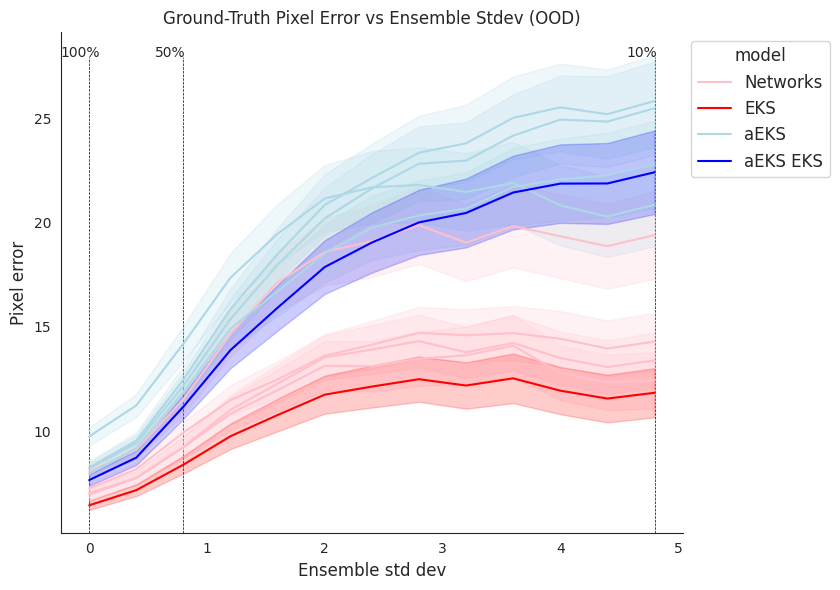

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the color mapping
color_mapping = {
    'networks': 'pink',
    'eks': 'red',
    'ens-mean': 'lightgreen',
    'ens-median': 'green',
    'aeks_rng': 'lightblue',
    'aeks_eks': 'blue',
    'aeks_ens-mean': 'orange',
    'aeks_ens-median': 'red'
}

# Create a color list based on the model names
def get_color(name):
    if 'aeks_ens-median' in name:
        return color_mapping['aeks_ens-median']
    elif 'aeks_ens-mean' in name:
        return color_mapping['aeks_ens-mean']
    elif 'aeks_rng' in name:
        return color_mapping['aeks_rng']
    elif 'aeks' in name:
        return color_mapping['aeks_eks']
    else:
        base_name = name.split('_')[0]
        return color_mapping.get(base_name, 'gray')

palette = [get_color(name) for name in df_line2['model'].unique()]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))  # Increase the figure size

g = sns.lineplot(
    x='ens-std',
    y='mean',
    hue='model',
    hue_order=model_names_list,
    palette=palette,
    data=df_line2,
    ax=ax,
    errorbar='se'
)

labels_fontsize = 12

ax.set_title(f'Ground-Truth Pixel Error vs Ensemble Stdev (OOD)', fontsize=labels_fontsize)
ax.set_ylabel('Pixel error', fontsize=labels_fontsize)
ax.set_xlabel('Ensemble std dev', fontsize=labels_fontsize)
cleanaxis(ax)

# Customize legend
legend_labels = {
    'networks': 'Networks',
    'eks': 'EKS',
    'ens-mean': 'Ensemble Mean',
    'ens-median': 'Ensemble Median',
    'aeks_rng': 'aEKS',
    'aeks_eks': 'aEKS EKS',
    'aeks_ens-mean': 'aEKS Ensemble Mean',
    'aeks_ens-median': 'aEKS Ensemble Median'
}

# Combine similar models into single legend entries
handles, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_handles = []

for handle, label in zip(handles, labels):
    if 'aeks_ens-median' in label:
        base_label = 'aeks_ens-median'
    elif 'aeks_ens-mean' in label:
        base_label = 'aeks_ens-mean'
    elif 'aeks_rng' in label:
        base_label = 'aeks_rng'
    elif 'aeks' in label:
        base_label = 'aeks_eks'
    else:
        base_label = label.split('_')[0]

    if base_label not in unique_labels:
        unique_labels.append(base_label)
        unique_handles.append(handle)

ax.legend(
    handles=unique_handles,
    labels=[legend_labels.get(label, label) for label in unique_labels],
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize=labels_fontsize,
    title='model',
    title_fontsize=labels_fontsize
)

# Plot annotations
percentiles = [100, 50, 1]
vals, prctiles = compute_percentiles(
    arr=n_points_dict[model_names_list[0]],
    std_vals=std_vals,
    percentiles=percentiles,
)

for p, v in zip(prctiles, vals):
    ax.axvline(v, ymax=0.95, linestyle='--', linewidth=0.5, color='k', zorder=-1)
    ax.text(
        v / np.diff(ax.get_xlim()), 0.95, str(round(p)) + '%',
        transform=ax.transAxes,
        ha='left',
    )

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.show()
